In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers

C:\Users\annek\AppData\Local\Temp\ipykernel_18140\4172943127.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)


Modified timestamps for file u00039s00001_hw00002.svc:
0     0
1     8
2    15
3    23
4    30
Name: timestamp, dtype: int32




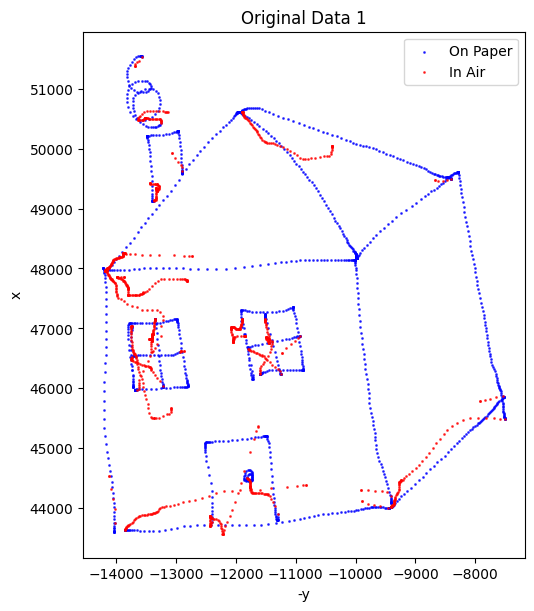

Processed data shape: (2491, 4)
Average number of data points: 2491


In [2]:
# Cell 2 (modified)
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        df = df.iloc[:, [0, 1, 2, 3]]  # Select x, y, timestamp, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    combined_data = np.vstack([np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                               for df, scaler in zip(data_frames, scalers)])
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, combined_data, scalers, avg_data_points

directory = 'Task2'  # Directory where the .svc files are stored
data_frames, combined_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=1)
print(f"Processed data shape: {combined_data.shape}")
print(f"Average number of data points: {avg_data_points}")


In [3]:
# Cell 3 (VAEGAN Model Definition)

import tensorflow as tf
import numpy as np

class VAEGAN(tf.keras.Model):
    def __init__(self, latent_dim, sequence_length, feature_dim, beta=1.0):
        super(VAEGAN, self).__init__()
        self.latent_dim = latent_dim
        self.sequence_length = sequence_length
        self.feature_dim = feature_dim
        self.beta = beta

        # Encoder
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(sequence_length, feature_dim)),
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(latent_dim * 2)
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(64 * sequence_length),
            tf.keras.layers.Reshape((sequence_length, 64)),
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(feature_dim))
        ])

        # Discriminator
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(sequence_length, feature_dim)),
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :, :3])
        pen_status = tf.sigmoid(decoded[:, :, 3:])
        return tf.concat([xy_timestamp, pen_status], axis=-1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mean, logvar

# Loss functions
def compute_reconstruction_loss(model, x, x_reconstructed):
    mse = tf.keras.losses.MeanSquaredError()
    return mse(x, x_reconstructed)

def compute_kl_loss(mean, logvar):
    return -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))

def compute_discriminator_loss(model, x_real, x_fake):
    real_output = model.discriminator(x_real)
    fake_output = model.discriminator(x_fake)
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    return tf.reduce_mean(real_loss + fake_loss)

def compute_generator_loss(model, x_fake):
    fake_output = model.discriminator(x_fake)
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))

# Training step
@tf.function
def train_step(model, x, optimizer_vae, optimizer_disc):
    with tf.GradientTape() as tape_vae, tf.GradientTape() as tape_disc:
        x_reconstructed, mean, logvar = model(x)
        
        # VAE losses
        reconstruction_loss = compute_reconstruction_loss(model, x, x_reconstructed)
        kl_loss = compute_kl_loss(mean, logvar)
        vae_loss = reconstruction_loss + model.beta * kl_loss
        
        # Discriminator loss
        disc_loss = compute_discriminator_loss(model, x, x_reconstructed)
        
        # Generator loss
        gen_loss = compute_generator_loss(model, x_reconstructed)
        
        # Total loss
        total_loss = vae_loss + gen_loss

    # Compute gradients and apply updates
    gradients_vae = tape_vae.gradient(total_loss, model.encoder.trainable_variables + model.decoder.trainable_variables)
    gradients_disc = tape_disc.gradient(disc_loss, model.discriminator.trainable_variables)
    
    optimizer_vae.apply_gradients(zip(gradients_vae, model.encoder.trainable_variables + model.decoder.trainable_variables))
    optimizer_disc.apply_gradients(zip(gradients_disc, model.discriminator.trainable_variables))

    return total_loss, reconstruction_loss, kl_loss, disc_loss, gen_loss

C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Starting training...
Total number of batches per epoch: 1

Epoch 1/50
--------------------


Epoch 1/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 1 Summary:
  Total Loss: 0.832492
  Reconstruction Loss: 0.127037
  KL Loss: 0.000824
  Discriminator Loss: 1.415806
  Generator Loss: 0.705455
  Epoch processing time: 452.94 seconds
  New best loss achieved!

Generating and visualizing augmented data for this epoch...


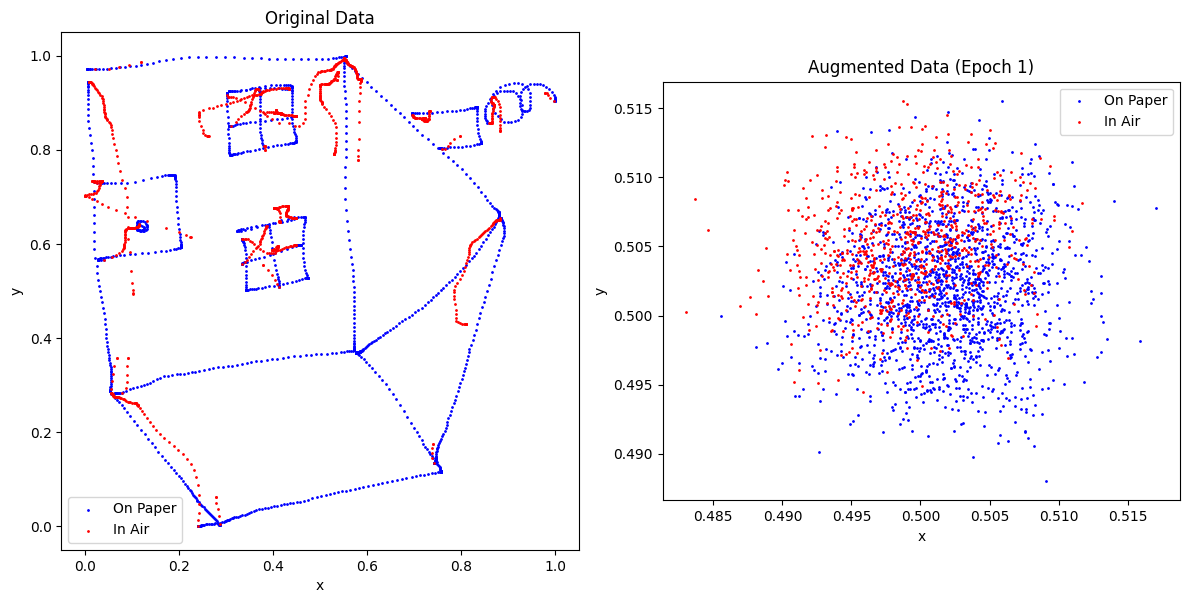


Epoch 2/50
--------------------


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 2 Summary:
  Total Loss: 0.789633
  Reconstruction Loss: 0.124396
  KL Loss: 0.000781
  Discriminator Loss: 1.343105
  Generator Loss: 0.665236
  Epoch processing time: 33.55 seconds
  New best loss achieved!

Generating and visualizing augmented data for this epoch...


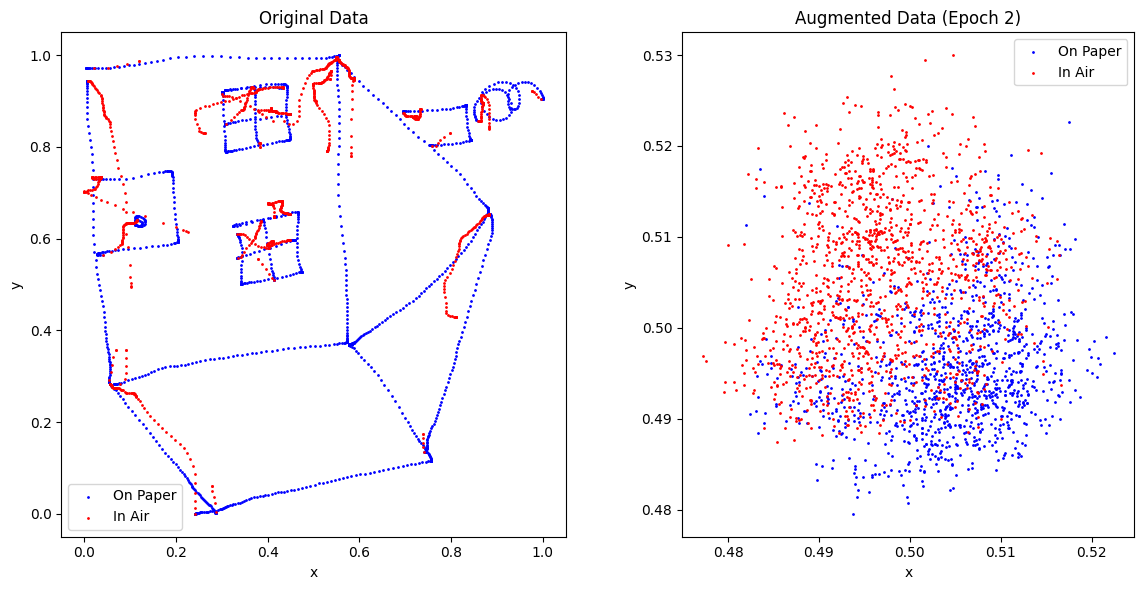


Epoch 3/50
--------------------


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 3 Summary:
  Total Loss: 0.764681
  Reconstruction Loss: 0.121557
  KL Loss: 0.000948
  Discriminator Loss: 1.282529
  Generator Loss: 0.643124
  Epoch processing time: 26.09 seconds
  New best loss achieved!

Generating and visualizing augmented data for this epoch...


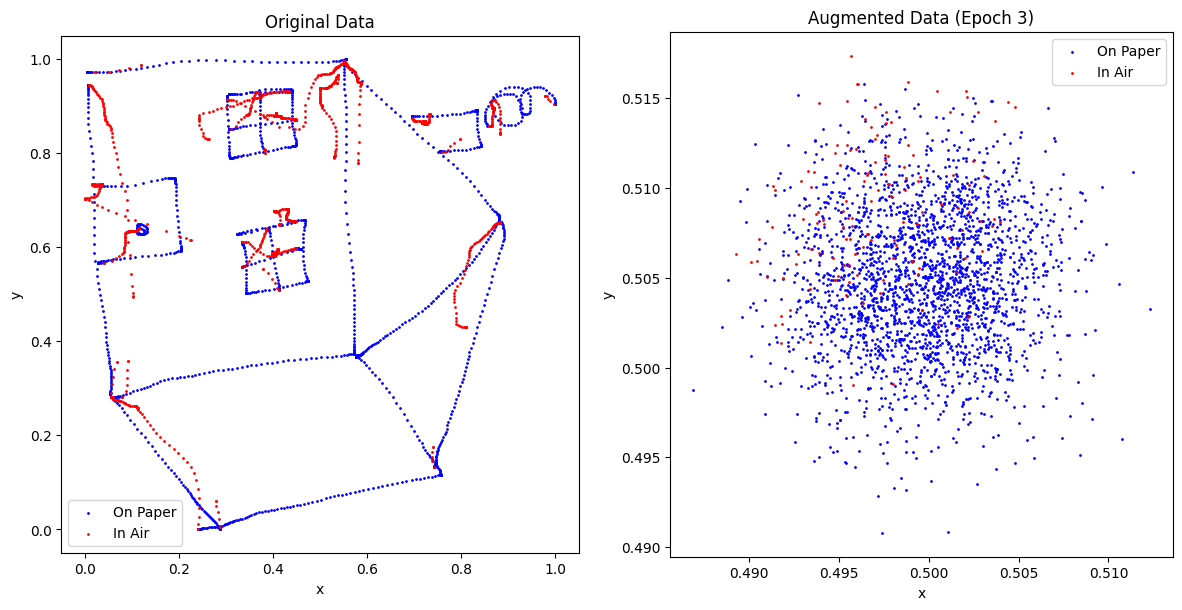


Epoch 4/50
--------------------


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 4 Summary:
  Total Loss: 0.756531
  Reconstruction Loss: 0.121157
  KL Loss: 0.001383
  Discriminator Loss: 1.221058
  Generator Loss: 0.635374
  Epoch processing time: 28.59 seconds
  New best loss achieved!

Generating and visualizing augmented data for this epoch...


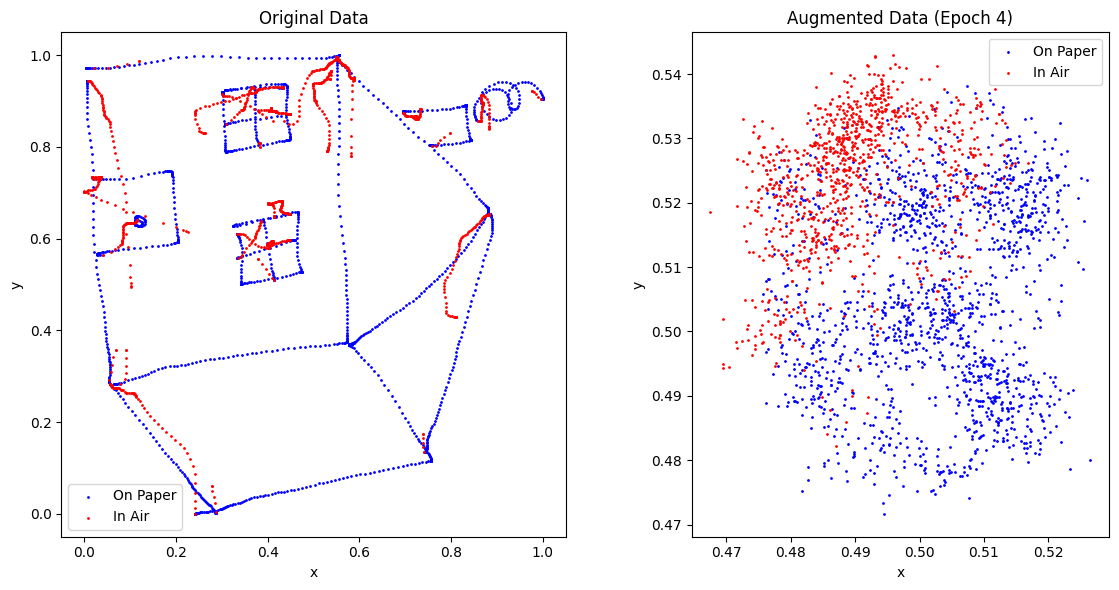


Epoch 5/50
--------------------


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 5 Summary:
  Total Loss: 0.774334
  Reconstruction Loss: 0.130806
  KL Loss: 0.002384
  Discriminator Loss: 1.149576
  Generator Loss: 0.643528
  Epoch processing time: 24.47 seconds
  No improvement. Patience: 1/30

Generating and visualizing augmented data for this epoch...


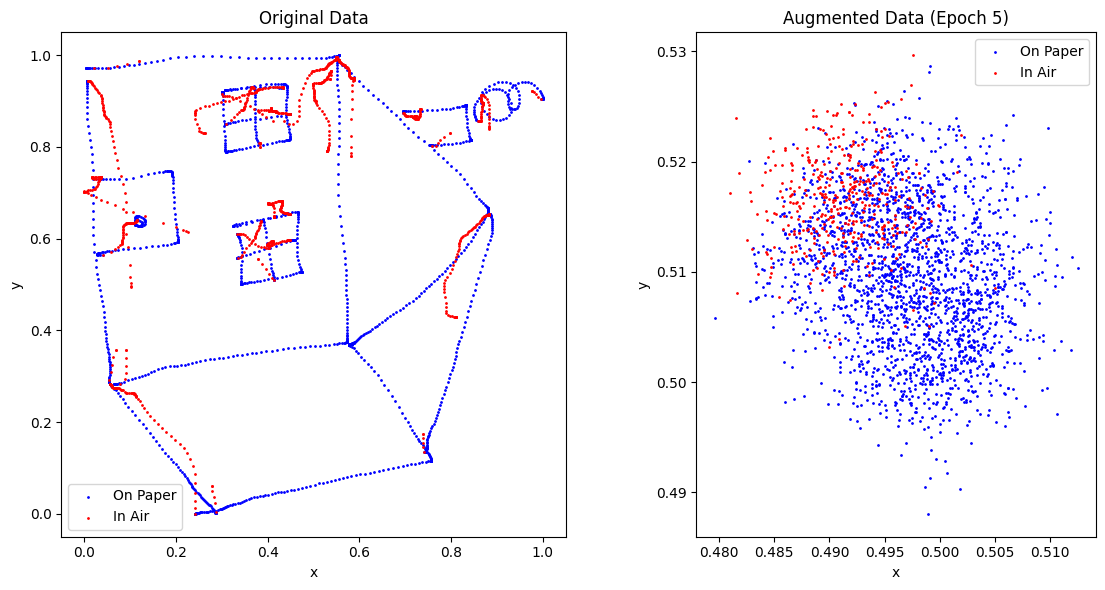


Epoch 6/50
--------------------


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 6 Summary:
  Total Loss: 0.763871
  Reconstruction Loss: 0.102434
  KL Loss: 0.004138
  Discriminator Loss: 1.071789
  Generator Loss: 0.661437
  Epoch processing time: 29.21 seconds
  No improvement. Patience: 2/30

Generating and visualizing augmented data for this epoch...


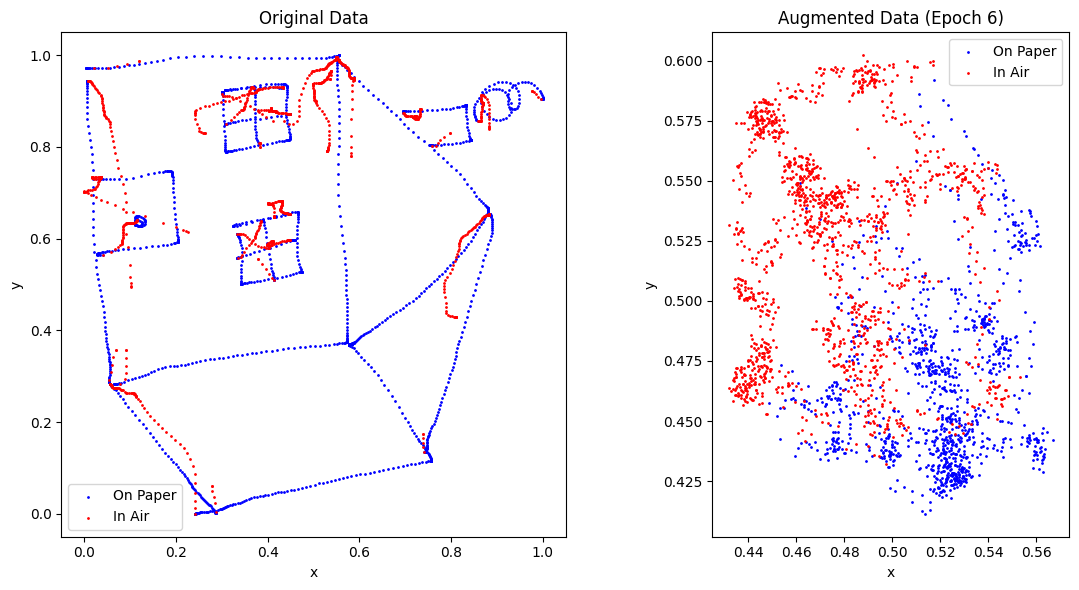


Epoch 7/50
--------------------


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 7 Summary:
  Total Loss: 0.849275
  Reconstruction Loss: 0.119701
  KL Loss: 0.007197
  Discriminator Loss: 0.949716
  Generator Loss: 0.729574
  Epoch processing time: 27.15 seconds
  No improvement. Patience: 3/30

Generating and visualizing augmented data for this epoch...


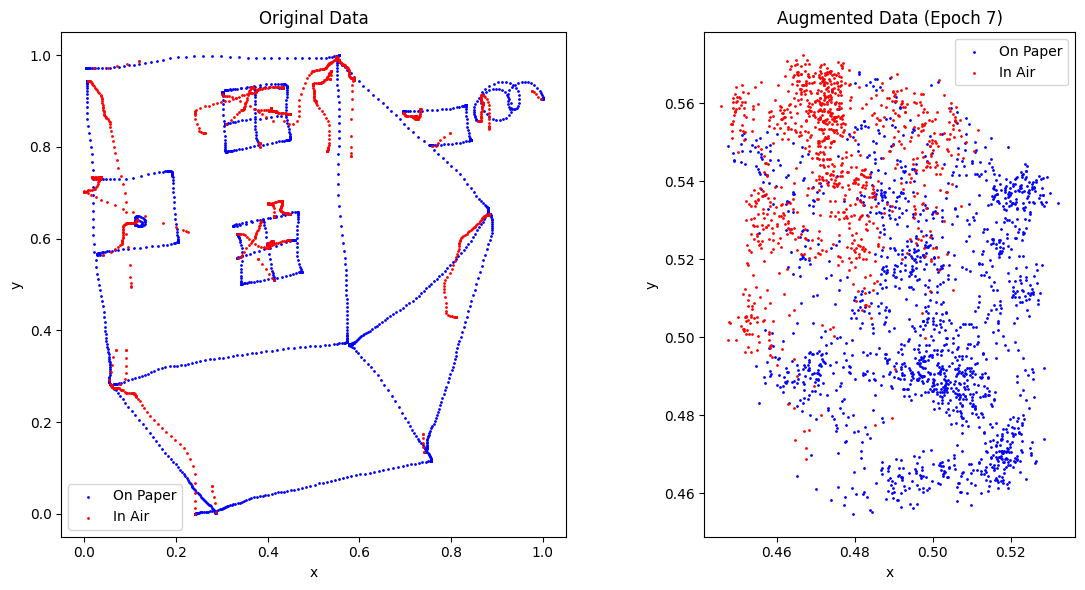


Epoch 8/50
--------------------


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 8 Summary:
  Total Loss: 1.004080
  Reconstruction Loss: 0.134876
  KL Loss: 0.012238
  Discriminator Loss: 0.779817
  Generator Loss: 0.869204
  Epoch processing time: 27.36 seconds
  No improvement. Patience: 4/30

Generating and visualizing augmented data for this epoch...


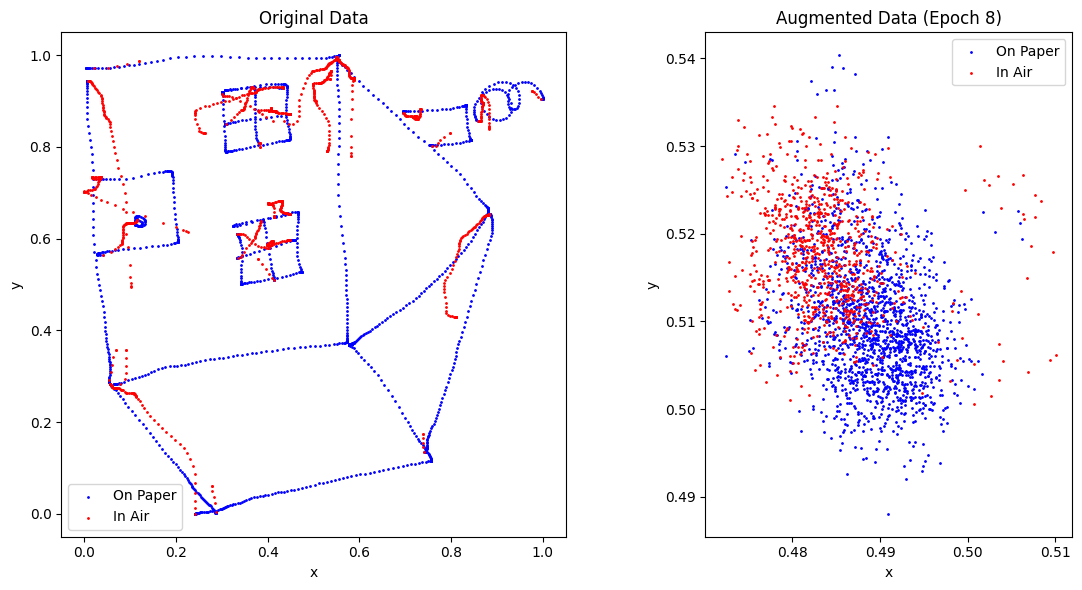


Epoch 9/50
--------------------


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 9 Summary:
  Total Loss: 1.087602
  Reconstruction Loss: 0.094437
  KL Loss: 0.020012
  Discriminator Loss: 0.634430
  Generator Loss: 0.993165
  Epoch processing time: 27.61 seconds
  No improvement. Patience: 5/30

Generating and visualizing augmented data for this epoch...


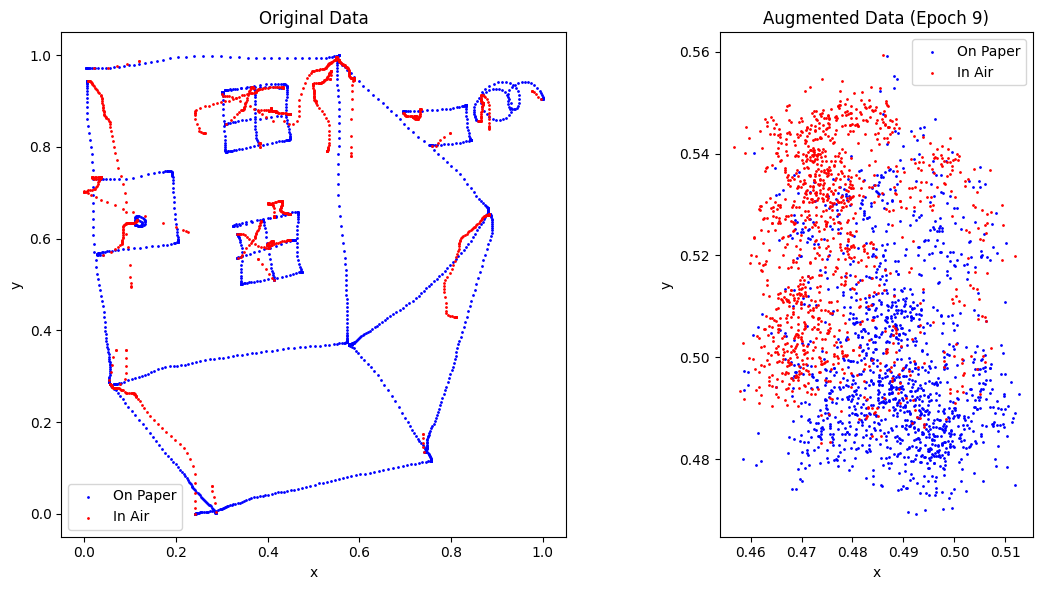


Epoch 10/50
--------------------


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 10 Summary:
  Total Loss: 1.390032
  Reconstruction Loss: 0.082426
  KL Loss: 0.030542
  Discriminator Loss: 0.427010
  Generator Loss: 1.307606
  Epoch processing time: 26.21 seconds
  No improvement. Patience: 6/30

Generating and visualizing augmented data for this epoch...


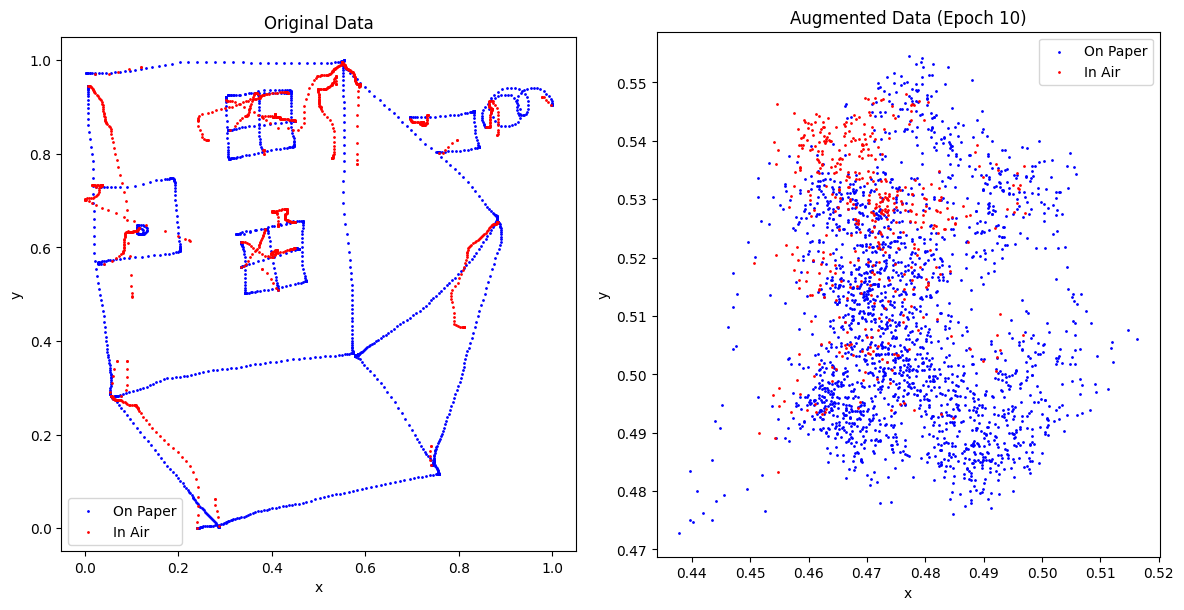


Epoch 11/50
--------------------


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 11 Summary:
  Total Loss: 1.782423
  Reconstruction Loss: 0.067978
  KL Loss: 0.043402
  Discriminator Loss: 0.260655
  Generator Loss: 1.714445
  Epoch processing time: 29.86 seconds
  No improvement. Patience: 7/30

Generating and visualizing augmented data for this epoch...


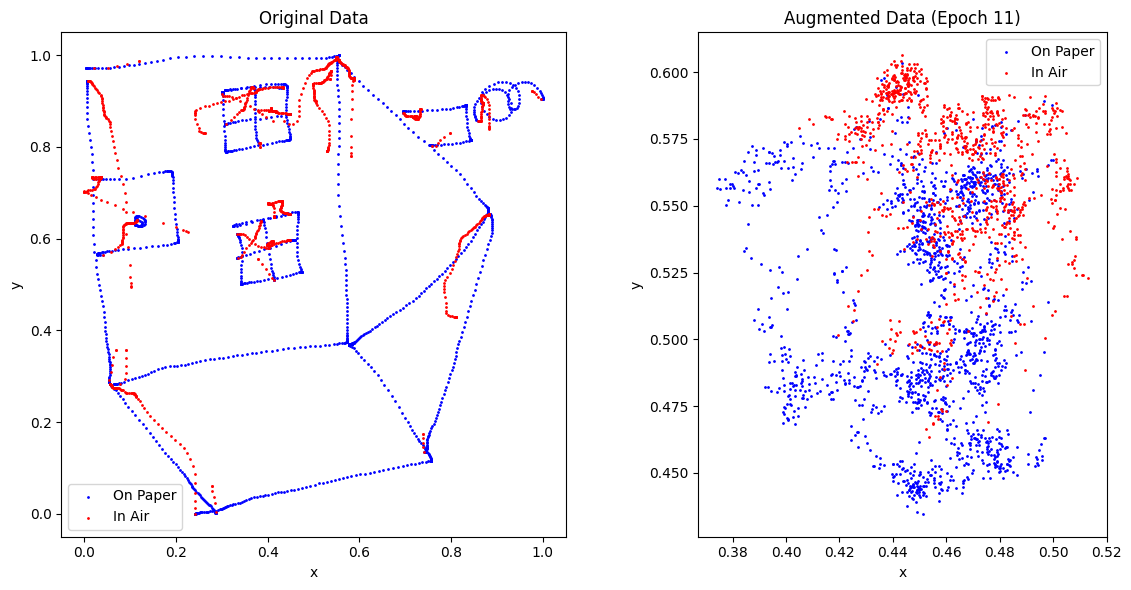


Epoch 12/50
--------------------


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 12 Summary:
  Total Loss: 2.228611
  Reconstruction Loss: 0.057960
  KL Loss: 0.058626
  Discriminator Loss: 0.152892
  Generator Loss: 2.170651
  Epoch processing time: 28.79 seconds
  No improvement. Patience: 8/30

Generating and visualizing augmented data for this epoch...


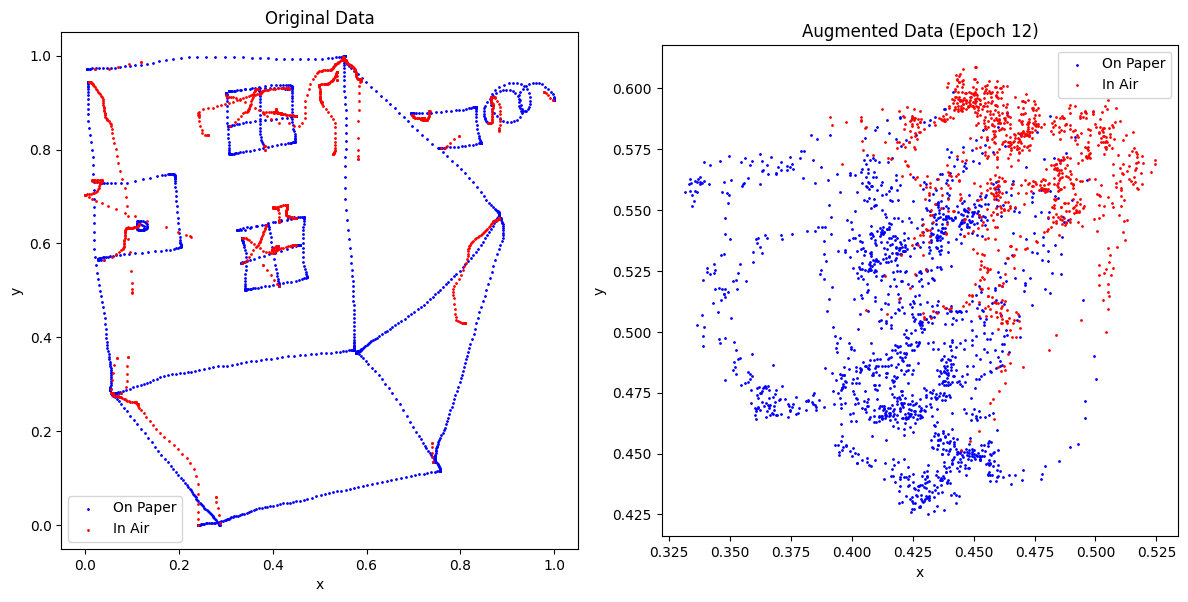


Epoch 13/50
--------------------


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 13 Summary:
  Total Loss: 2.598719
  Reconstruction Loss: 0.048937
  KL Loss: 0.076159
  Discriminator Loss: 2.495997
  Generator Loss: 2.549782
  Epoch processing time: 27.77 seconds
  No improvement. Patience: 9/30

Generating and visualizing augmented data for this epoch...


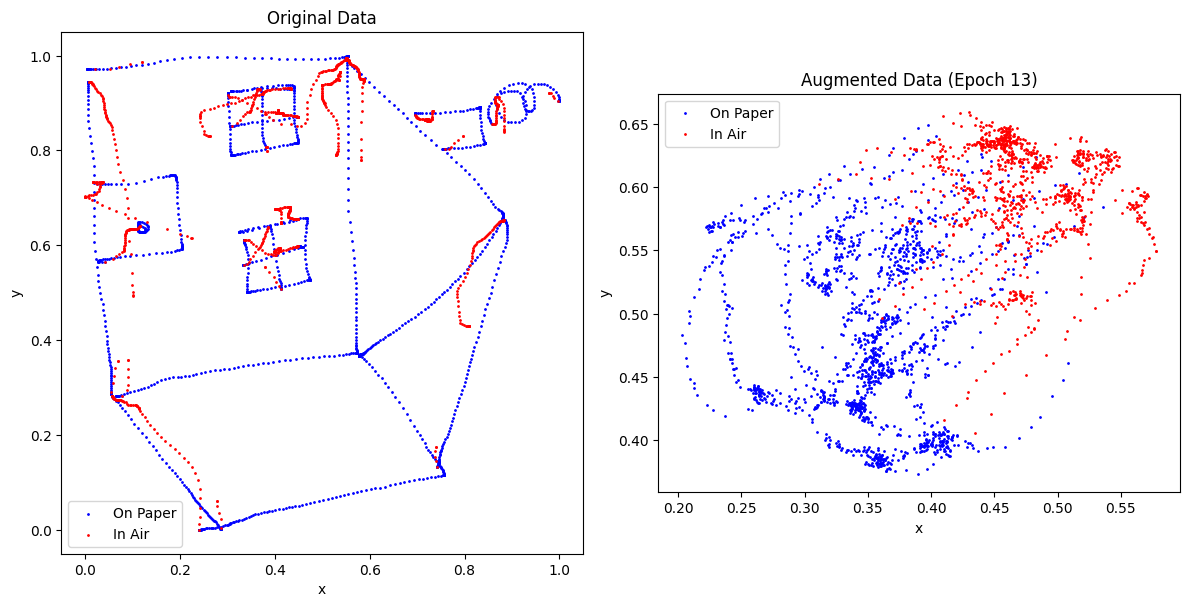


Epoch 14/50
--------------------


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 14 Summary:
  Total Loss: 2.241088
  Reconstruction Loss: 0.048093
  KL Loss: 0.096187
  Discriminator Loss: 0.139022
  Generator Loss: 2.192996
  Epoch processing time: 29.44 seconds
  No improvement. Patience: 10/30

Generating and visualizing augmented data for this epoch...


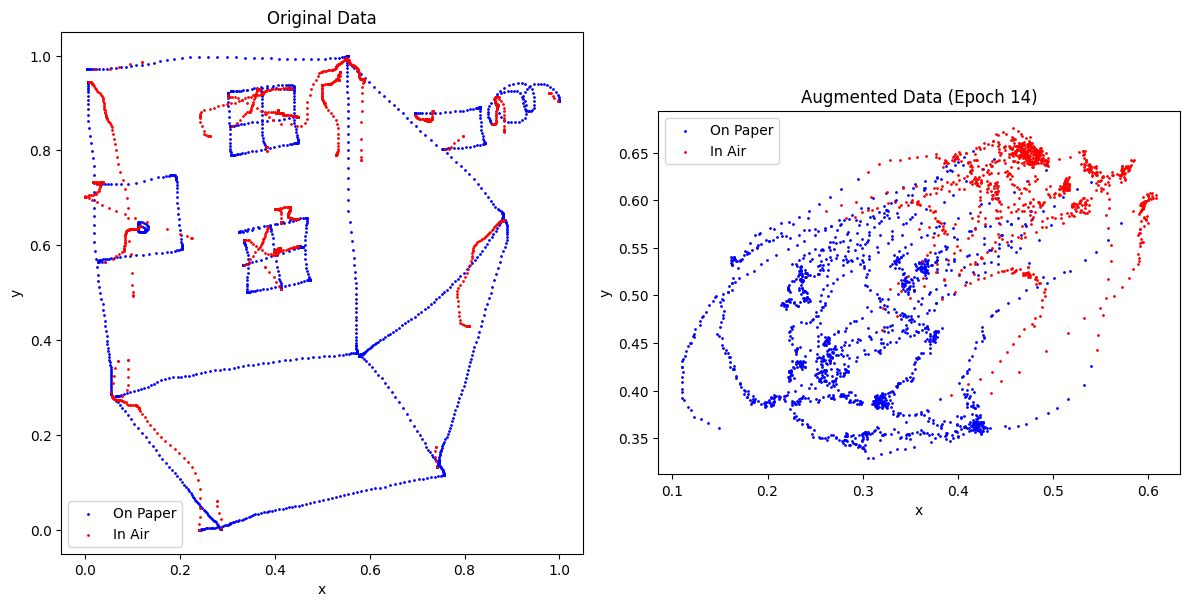


Epoch 15/50
--------------------


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 15 Summary:
  Total Loss: 0.073698
  Reconstruction Loss: 0.054411
  KL Loss: 0.119006
  Discriminator Loss: 3.976339
  Generator Loss: 0.019287
  Epoch processing time: 26.59 seconds
  New best loss achieved!

Generating and visualizing augmented data for this epoch...


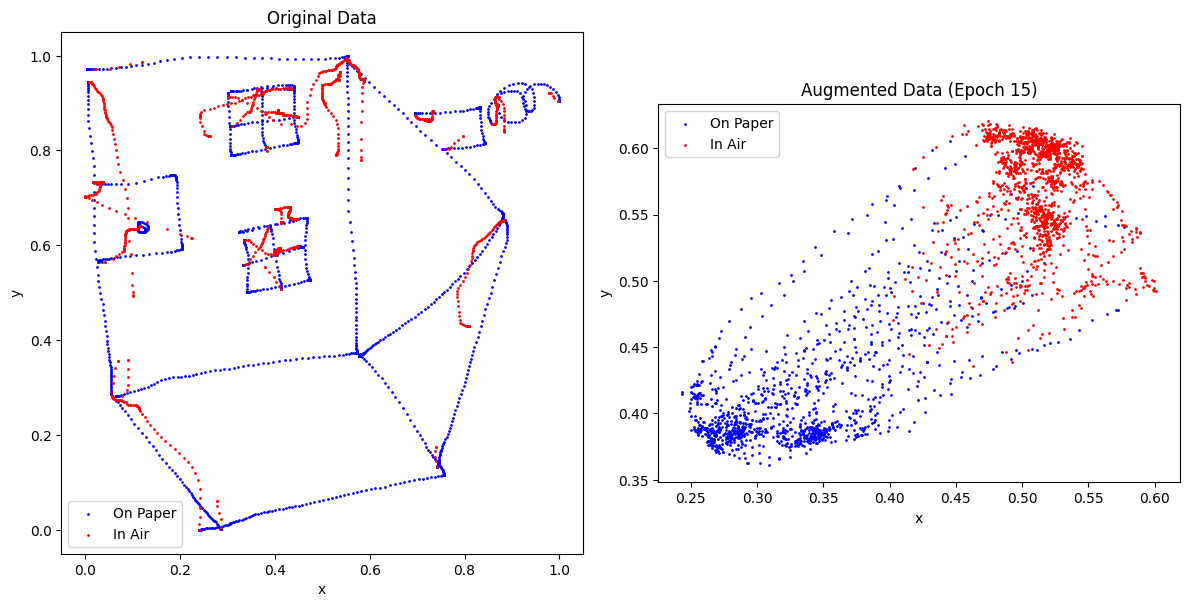


Epoch 16/50
--------------------


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 16 Summary:
  Total Loss: 0.070279
  Reconstruction Loss: 0.048807
  KL Loss: 0.142449
  Discriminator Loss: 3.872180
  Generator Loss: 0.021472
  Epoch processing time: 32.97 seconds
  New best loss achieved!

Generating and visualizing augmented data for this epoch...


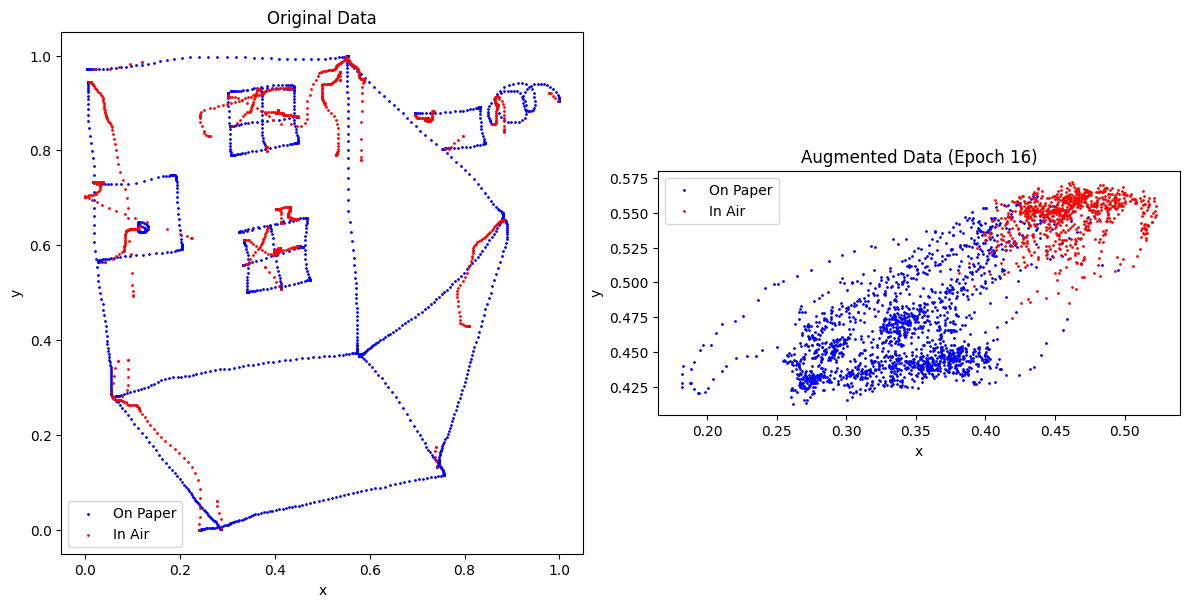


Epoch 17/50
--------------------


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 17 Summary:
  Total Loss: 0.076282
  Reconstruction Loss: 0.050620
  KL Loss: 0.166279
  Discriminator Loss: 3.700025
  Generator Loss: 0.025662
  Epoch processing time: 27.61 seconds
  No improvement. Patience: 1/30

Generating and visualizing augmented data for this epoch...


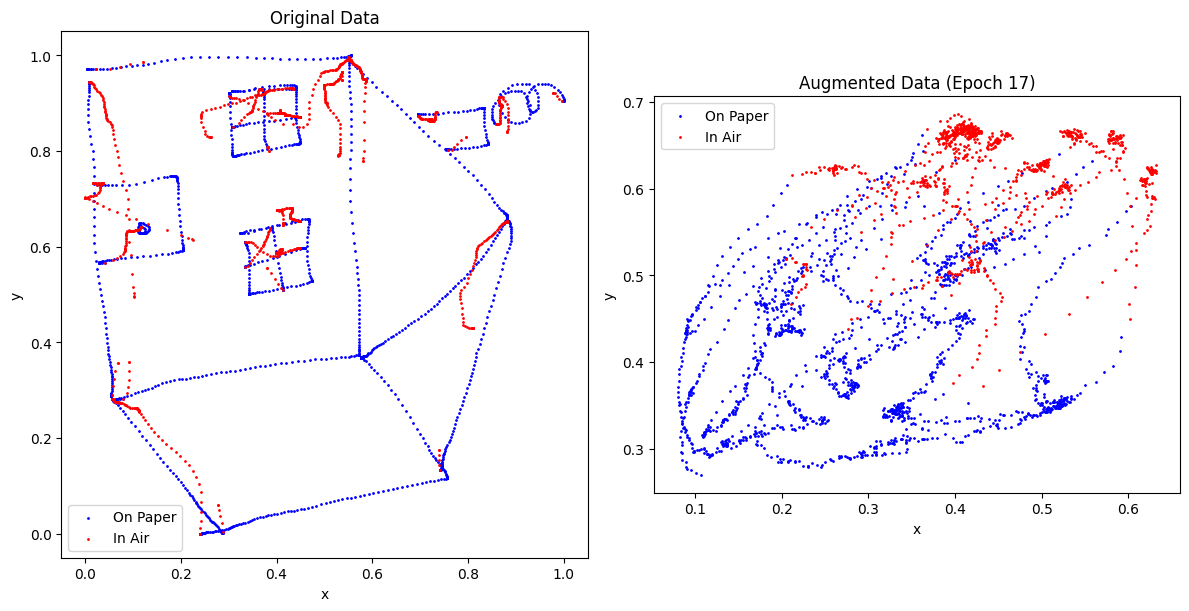


Epoch 18/50
--------------------


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 18 Summary:
  Total Loss: 0.078477
  Reconstruction Loss: 0.046435
  KL Loss: 0.190746
  Discriminator Loss: 3.487247
  Generator Loss: 0.032042
  Epoch processing time: 29.16 seconds
  No improvement. Patience: 2/30

Generating and visualizing augmented data for this epoch...


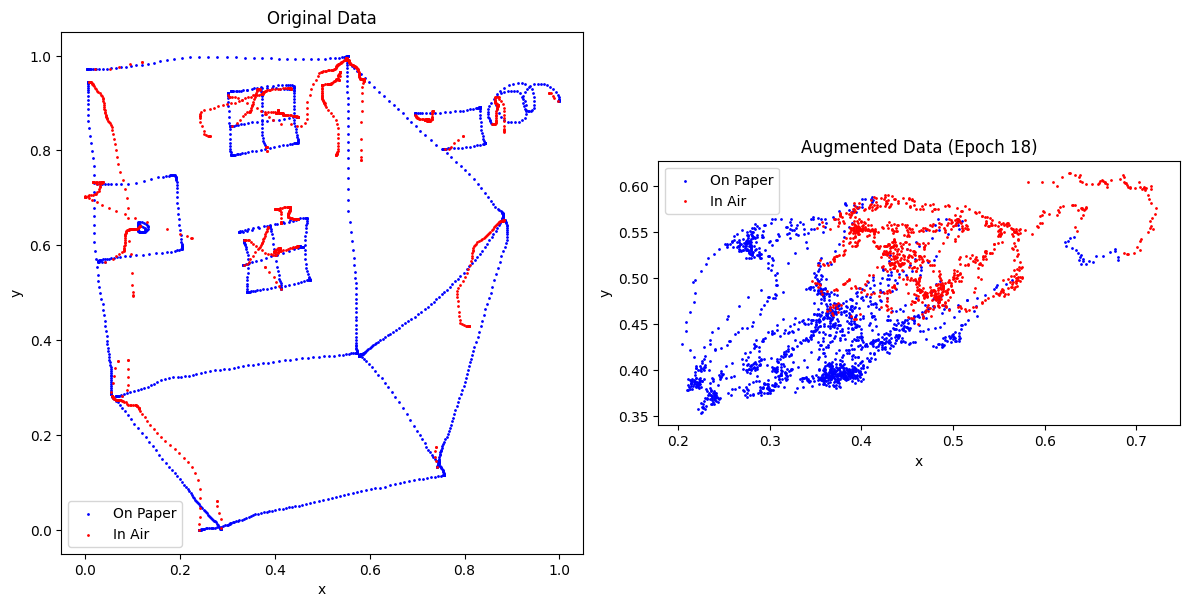


Epoch 19/50
--------------------


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 19 Summary:
  Total Loss: 0.079313
  Reconstruction Loss: 0.038483
  KL Loss: 0.216064
  Discriminator Loss: 3.257703
  Generator Loss: 0.040830
  Epoch processing time: 28.74 seconds
  No improvement. Patience: 3/30

Generating and visualizing augmented data for this epoch...


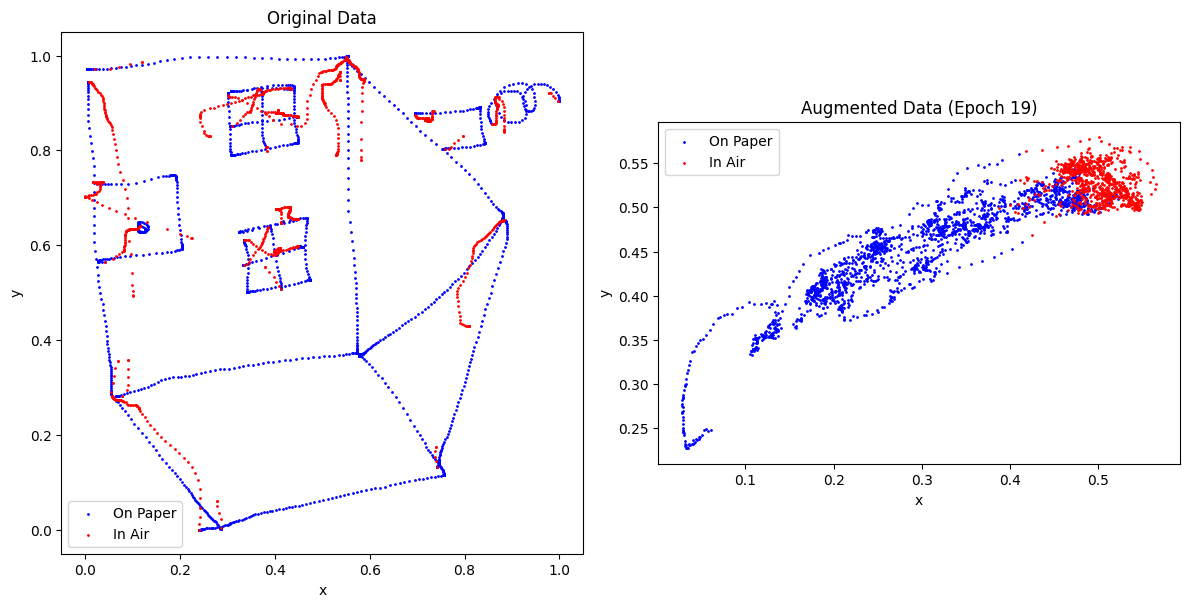


Epoch 20/50
--------------------


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 20 Summary:
  Total Loss: 0.085670
  Reconstruction Loss: 0.033327
  KL Loss: 0.242074
  Discriminator Loss: 3.026179
  Generator Loss: 0.052342
  Epoch processing time: 31.60 seconds
  No improvement. Patience: 4/30

Generating and visualizing augmented data for this epoch...


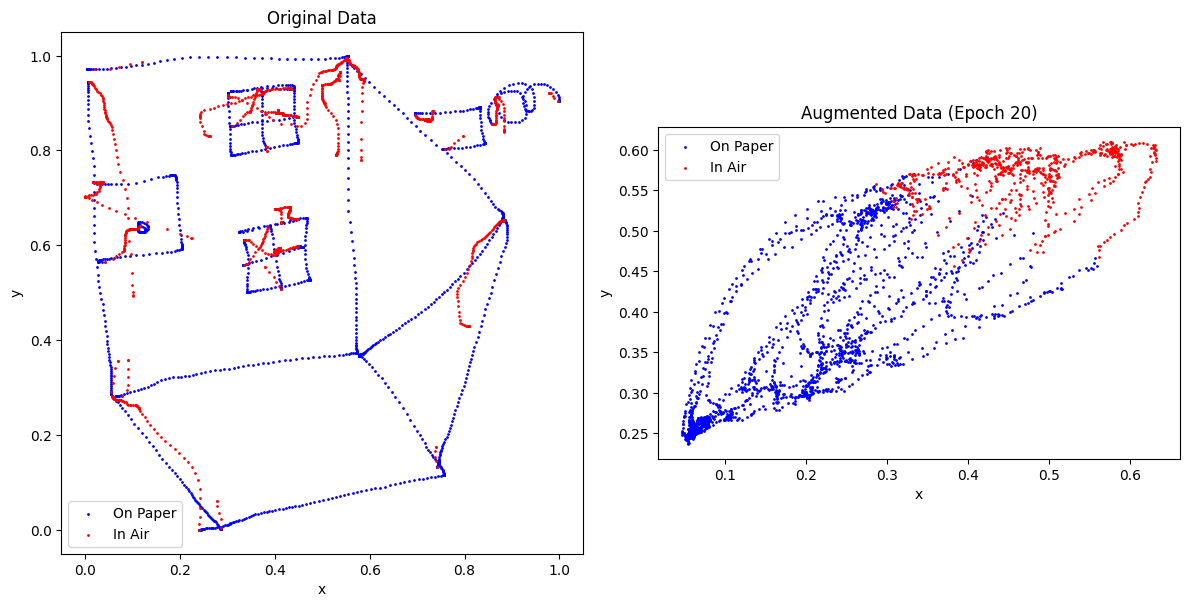


Epoch 21/50
--------------------


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 21 Summary:
  Total Loss: 0.096628
  Reconstruction Loss: 0.029730
  KL Loss: 0.268498
  Discriminator Loss: 2.802251
  Generator Loss: 0.066898
  Epoch processing time: 28.60 seconds
  No improvement. Patience: 5/30

Generating and visualizing augmented data for this epoch...


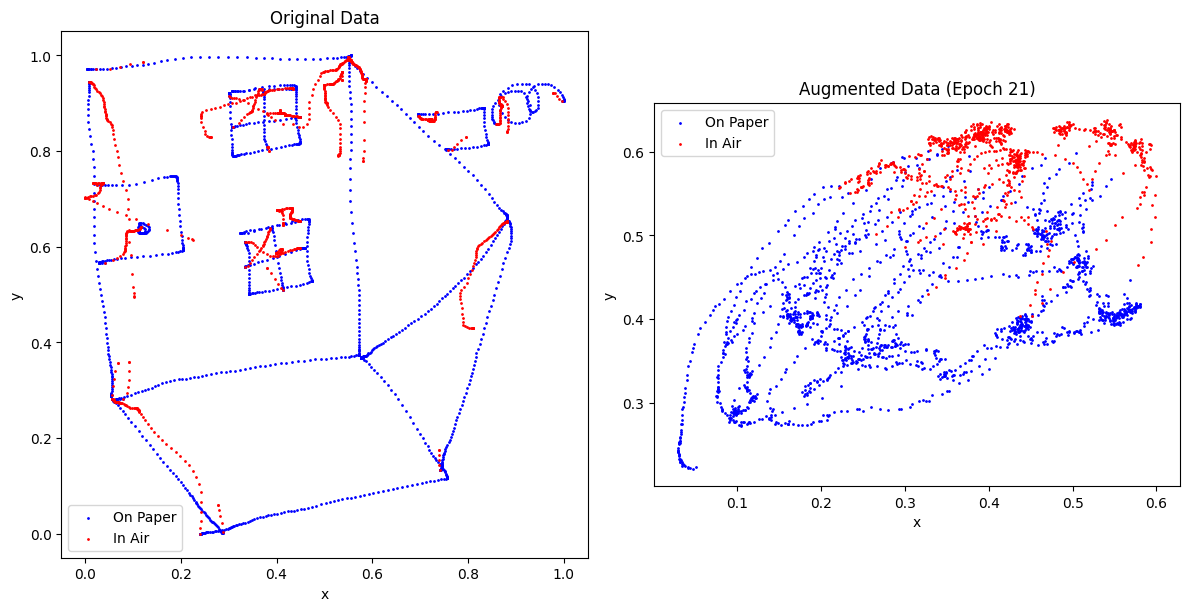


Epoch 22/50
--------------------


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 22 Summary:
  Total Loss: 0.109064
  Reconstruction Loss: 0.024288
  KL Loss: 0.295094
  Discriminator Loss: 2.591966
  Generator Loss: 0.084776
  Epoch processing time: 27.16 seconds
  No improvement. Patience: 6/30

Generating and visualizing augmented data for this epoch...


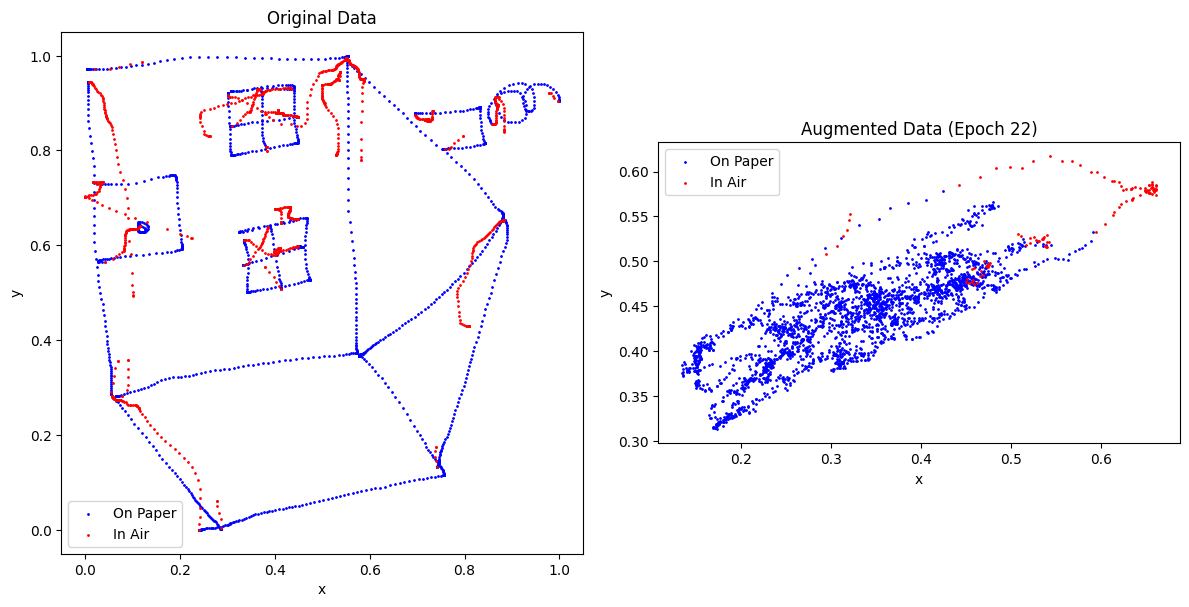


Epoch 23/50
--------------------


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 23 Summary:
  Total Loss: 0.126022
  Reconstruction Loss: 0.019582
  KL Loss: 0.321371
  Discriminator Loss: 2.396775
  Generator Loss: 0.106439
  Epoch processing time: 32.47 seconds
  No improvement. Patience: 7/30

Generating and visualizing augmented data for this epoch...


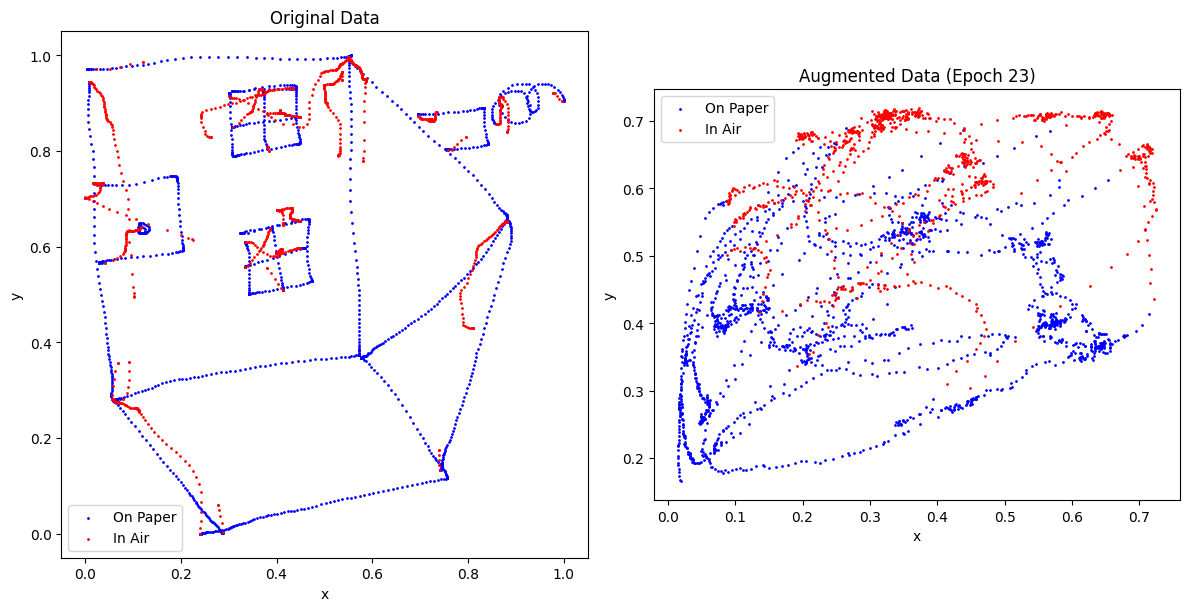


Epoch 24/50
--------------------


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 24 Summary:
  Total Loss: 0.150044
  Reconstruction Loss: 0.017880
  KL Loss: 0.346905
  Discriminator Loss: 2.218879
  Generator Loss: 0.132164
  Epoch processing time: 28.11 seconds
  No improvement. Patience: 8/30

Generating and visualizing augmented data for this epoch...


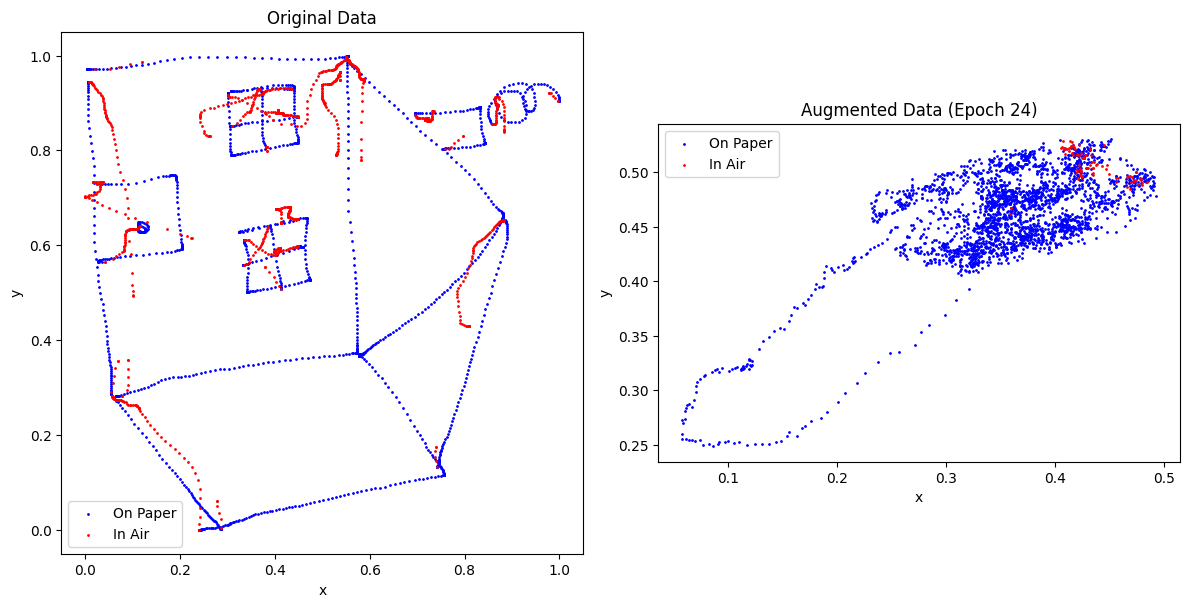


Epoch 25/50
--------------------


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 25 Summary:
  Total Loss: 0.178145
  Reconstruction Loss: 0.015893
  KL Loss: 0.371620
  Discriminator Loss: 2.058825
  Generator Loss: 0.162252
  Epoch processing time: 38.51 seconds
  No improvement. Patience: 9/30

Generating and visualizing augmented data for this epoch...


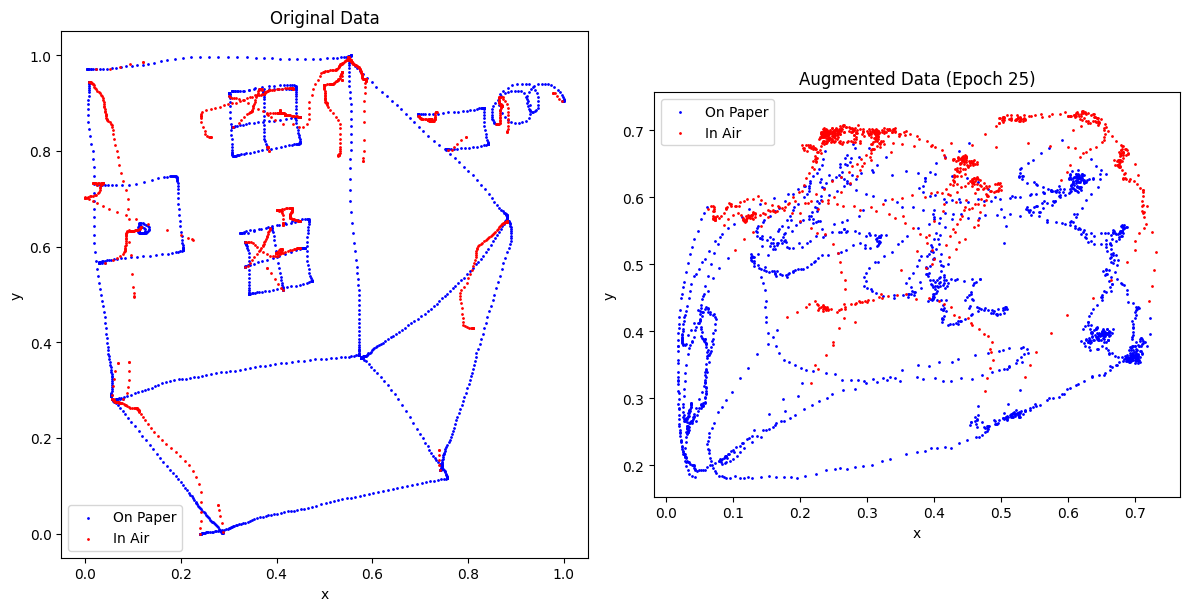


Epoch 26/50
--------------------


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 26 Summary:
  Total Loss: 0.210882
  Reconstruction Loss: 0.013950
  KL Loss: 0.395238
  Discriminator Loss: 1.917019
  Generator Loss: 0.196932
  Epoch processing time: 37.63 seconds
  No improvement. Patience: 10/30

Generating and visualizing augmented data for this epoch...


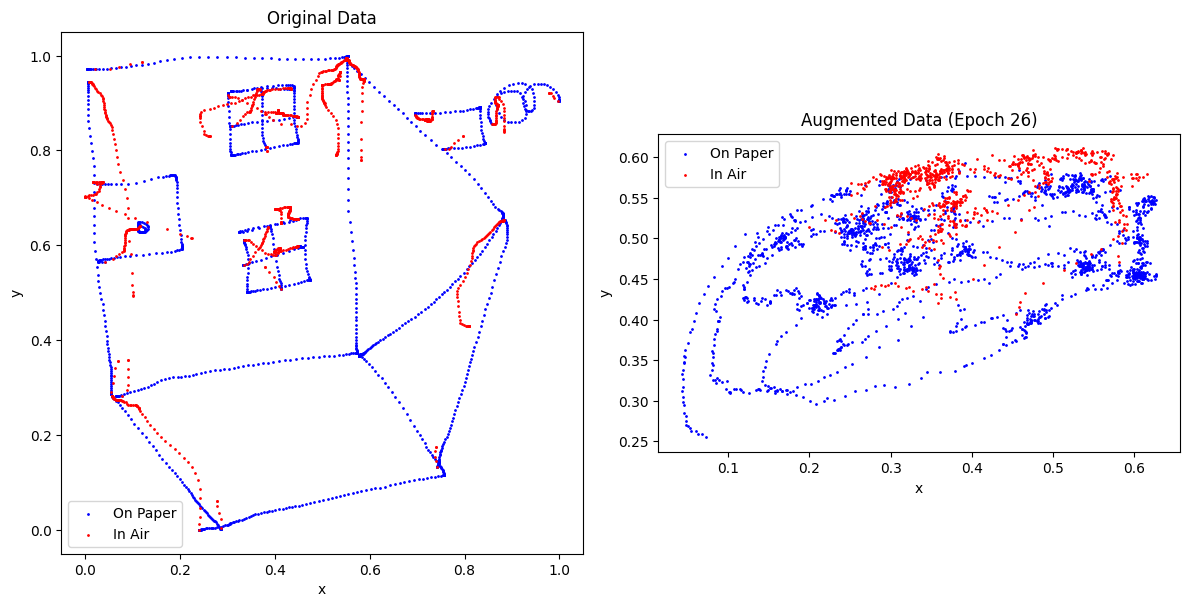


Epoch 27/50
--------------------


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 27 Summary:
  Total Loss: 0.250330
  Reconstruction Loss: 0.013386
  KL Loss: 0.417259
  Discriminator Loss: 1.791517
  Generator Loss: 0.236944
  Epoch processing time: 33.17 seconds
  No improvement. Patience: 11/30

Generating and visualizing augmented data for this epoch...


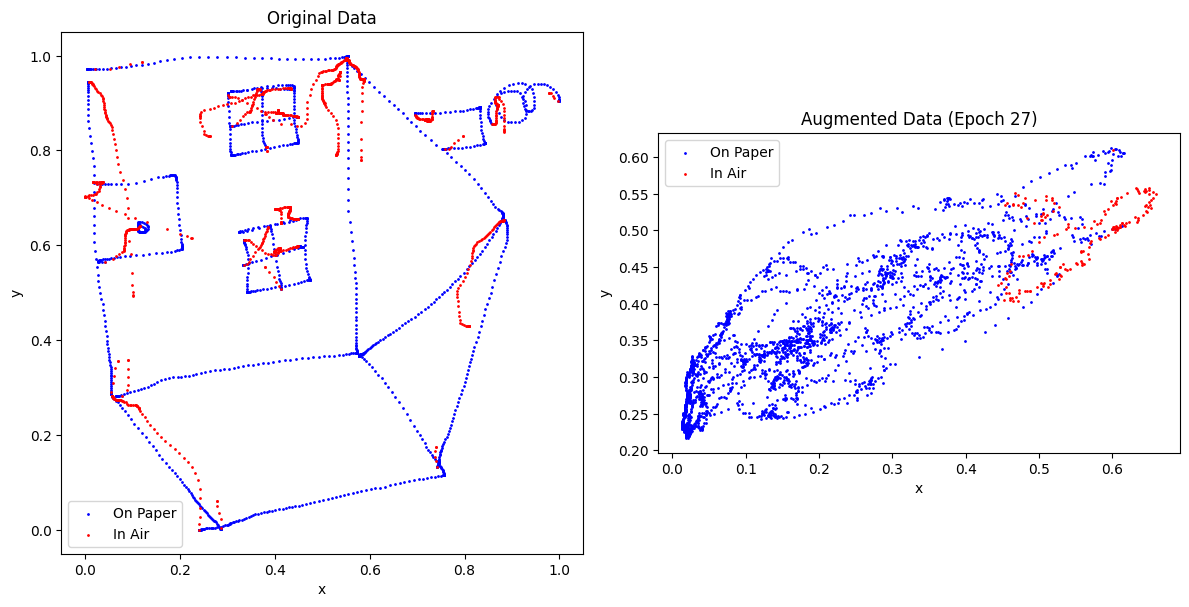


Epoch 28/50
--------------------


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 28 Summary:
  Total Loss: 0.296565
  Reconstruction Loss: 0.014058
  KL Loss: 0.437522
  Discriminator Loss: 1.683050
  Generator Loss: 0.282507
  Epoch processing time: 31.15 seconds
  No improvement. Patience: 12/30

Generating and visualizing augmented data for this epoch...


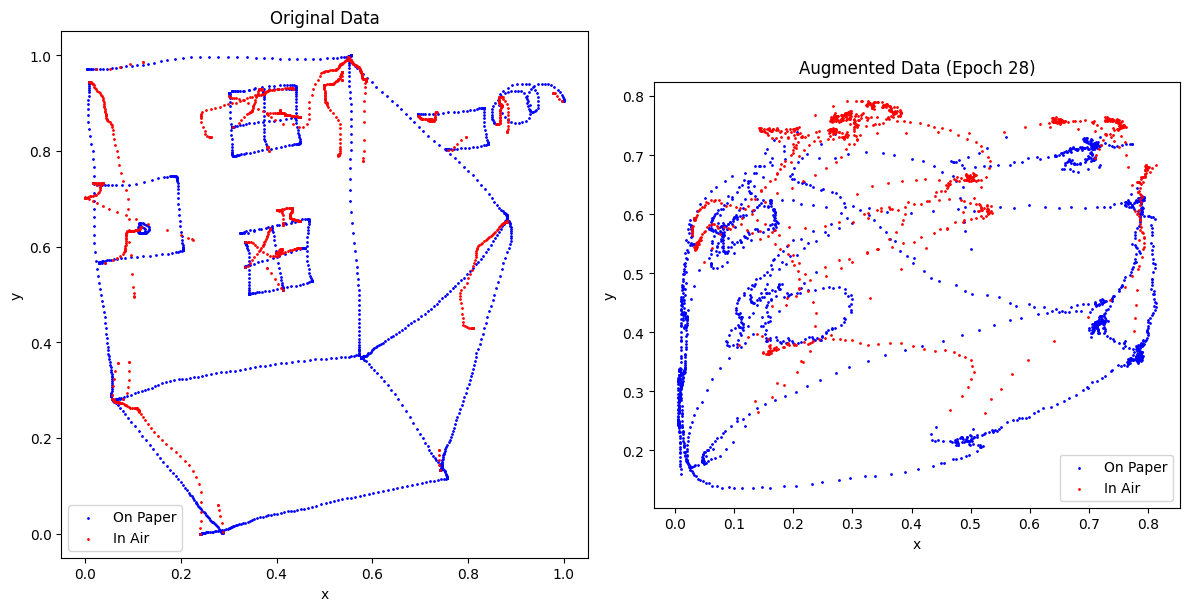


Epoch 29/50
--------------------


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 29 Summary:
  Total Loss: 0.343959
  Reconstruction Loss: 0.010148
  KL Loss: 0.456190
  Discriminator Loss: 1.591698
  Generator Loss: 0.333811
  Epoch processing time: 27.60 seconds
  No improvement. Patience: 13/30

Generating and visualizing augmented data for this epoch...


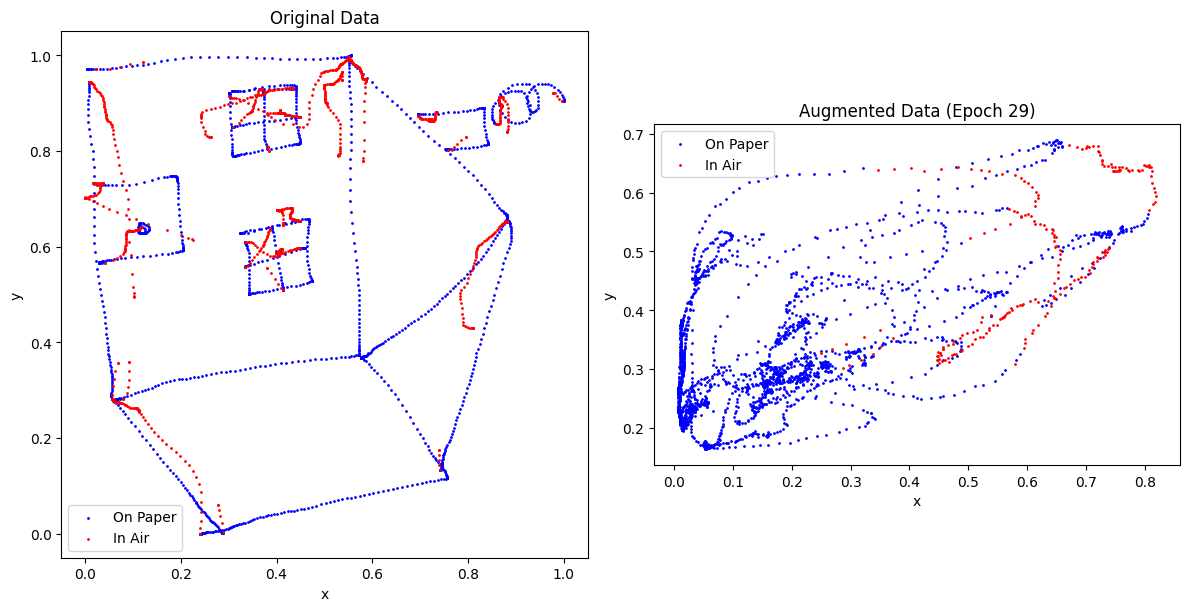


Epoch 30/50
--------------------


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 30 Summary:
  Total Loss: 0.400440
  Reconstruction Loss: 0.009792
  KL Loss: 0.473218
  Discriminator Loss: 1.517790
  Generator Loss: 0.390648
  Epoch processing time: 31.02 seconds
  No improvement. Patience: 14/30

Generating and visualizing augmented data for this epoch...


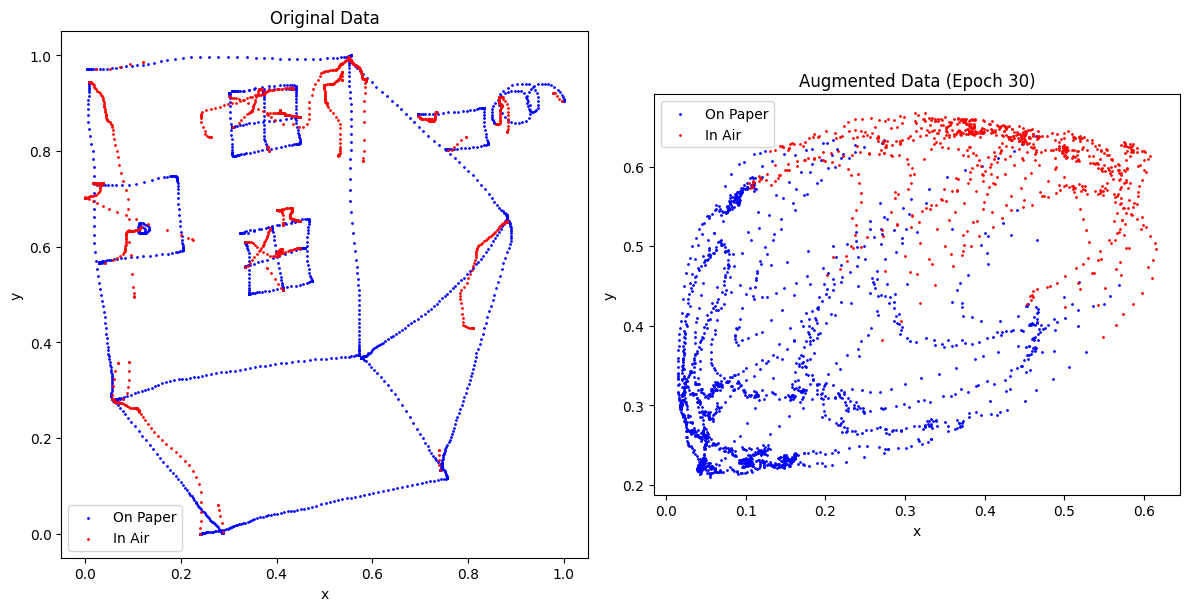


Epoch 31/50
--------------------


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 31 Summary:
  Total Loss: 0.461182
  Reconstruction Loss: 0.008473
  KL Loss: 0.488791
  Discriminator Loss: 1.460913
  Generator Loss: 0.452709
  Epoch processing time: 32.66 seconds
  No improvement. Patience: 15/30

Generating and visualizing augmented data for this epoch...


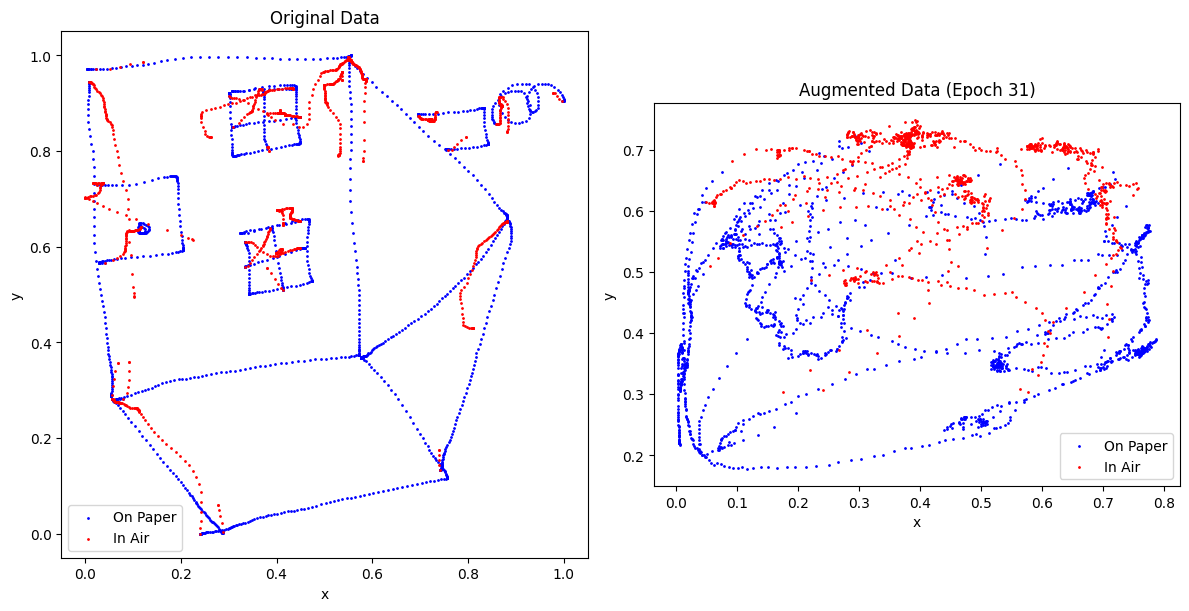


Epoch 32/50
--------------------


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 32 Summary:
  Total Loss: 0.527259
  Reconstruction Loss: 0.007895
  KL Loss: 0.503004
  Discriminator Loss: 1.420498
  Generator Loss: 0.519364
  Epoch processing time: 27.99 seconds
  No improvement. Patience: 16/30

Generating and visualizing augmented data for this epoch...


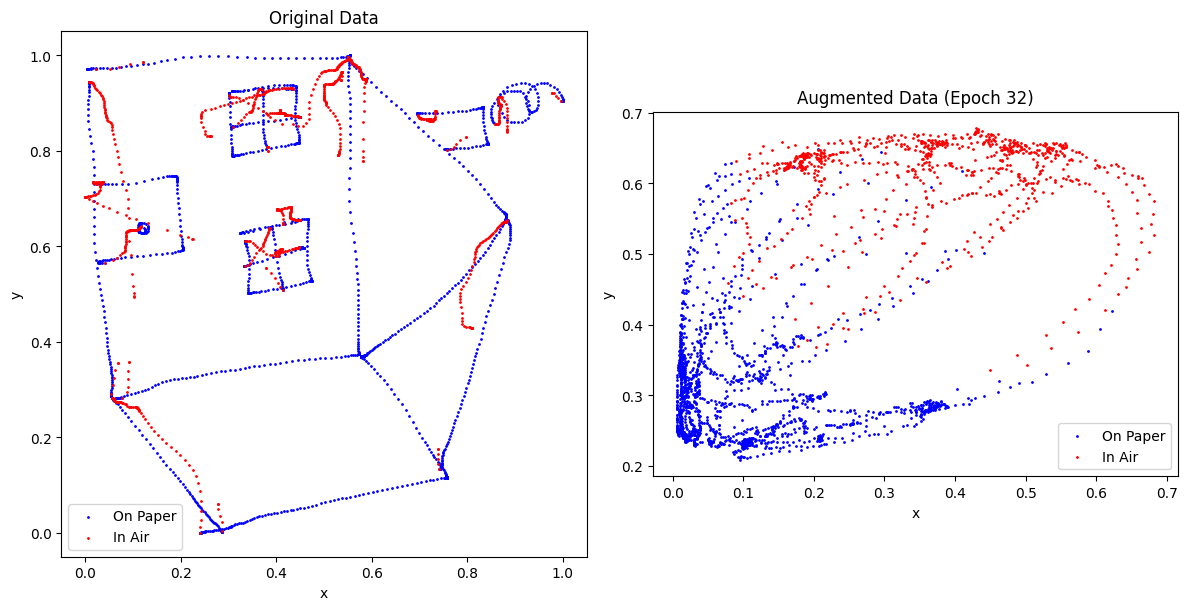


Epoch 33/50
--------------------


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 33 Summary:
  Total Loss: 0.597720
  Reconstruction Loss: 0.007837
  KL Loss: 0.515900
  Discriminator Loss: 1.395297
  Generator Loss: 0.589883
  Epoch processing time: 36.65 seconds
  No improvement. Patience: 17/30

Generating and visualizing augmented data for this epoch...


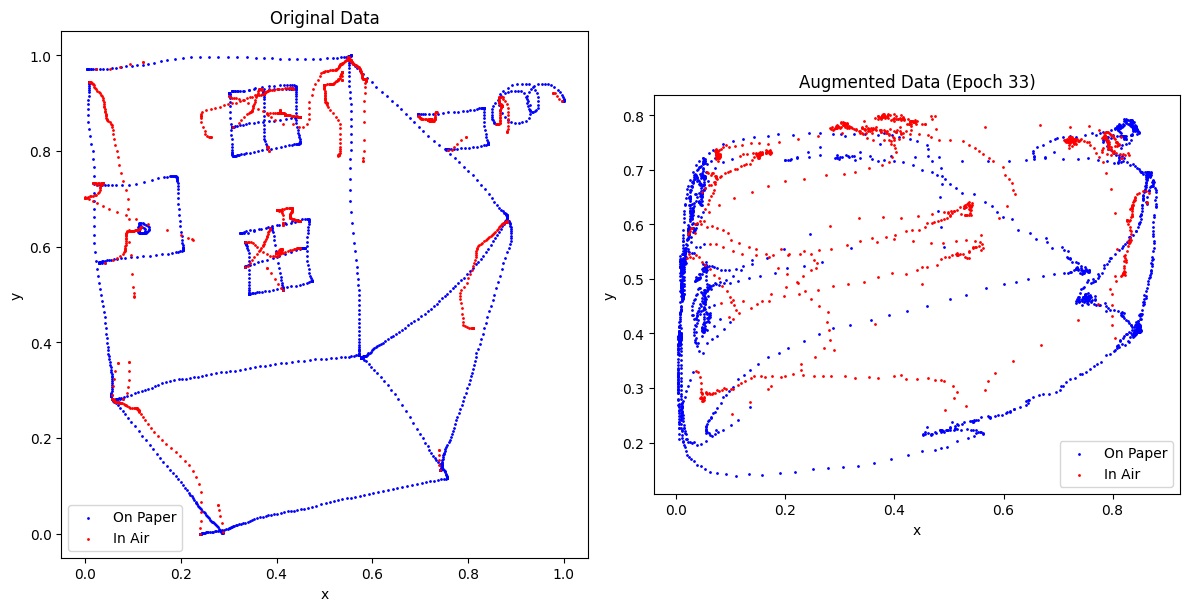


Epoch 34/50
--------------------


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 34 Summary:
  Total Loss: 0.669228
  Reconstruction Loss: 0.006788
  KL Loss: 0.527721
  Discriminator Loss: 1.383995
  Generator Loss: 0.662441
  Epoch processing time: 29.19 seconds
  No improvement. Patience: 18/30

Generating and visualizing augmented data for this epoch...


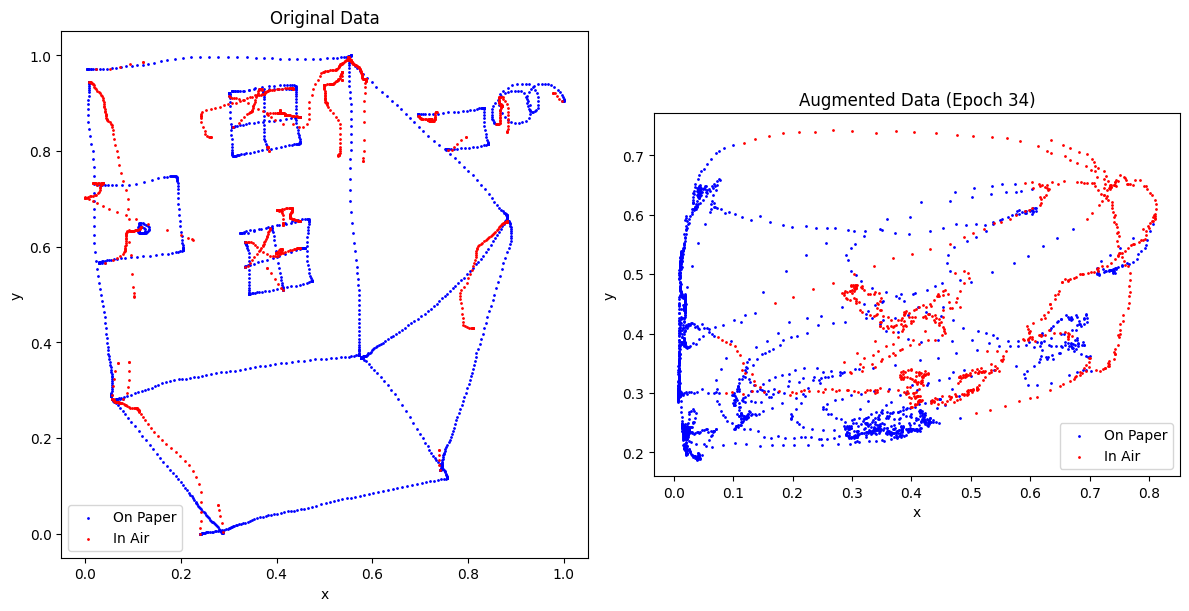


Epoch 35/50
--------------------


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 35 Summary:
  Total Loss: 0.740235
  Reconstruction Loss: 0.006672
  KL Loss: 0.538724
  Discriminator Loss: 1.384211
  Generator Loss: 0.733564
  Epoch processing time: 28.80 seconds
  No improvement. Patience: 19/30

Generating and visualizing augmented data for this epoch...


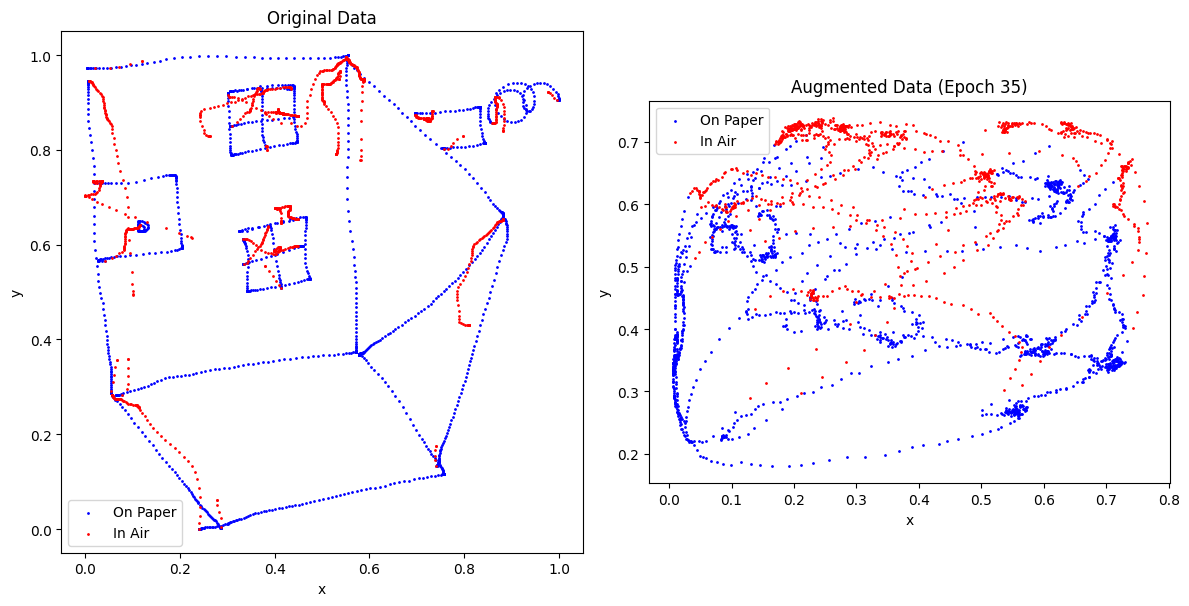


Epoch 36/50
--------------------


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 36 Summary:
  Total Loss: 0.803214
  Reconstruction Loss: 0.005314
  KL Loss: 0.549255
  Discriminator Loss: 1.392323
  Generator Loss: 0.797900
  Epoch processing time: 31.96 seconds
  No improvement. Patience: 20/30

Generating and visualizing augmented data for this epoch...


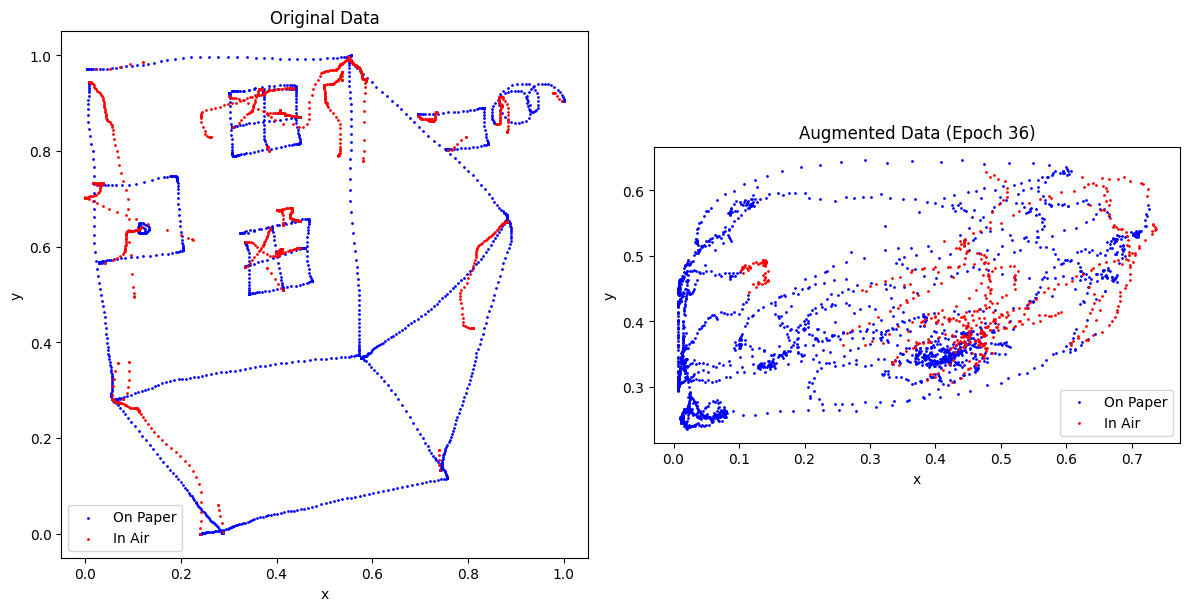


Epoch 37/50
--------------------


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 37 Summary:
  Total Loss: 0.855648
  Reconstruction Loss: 0.004777
  KL Loss: 0.558880
  Discriminator Loss: 1.403663
  Generator Loss: 0.850871
  Epoch processing time: 30.19 seconds
  No improvement. Patience: 21/30

Generating and visualizing augmented data for this epoch...


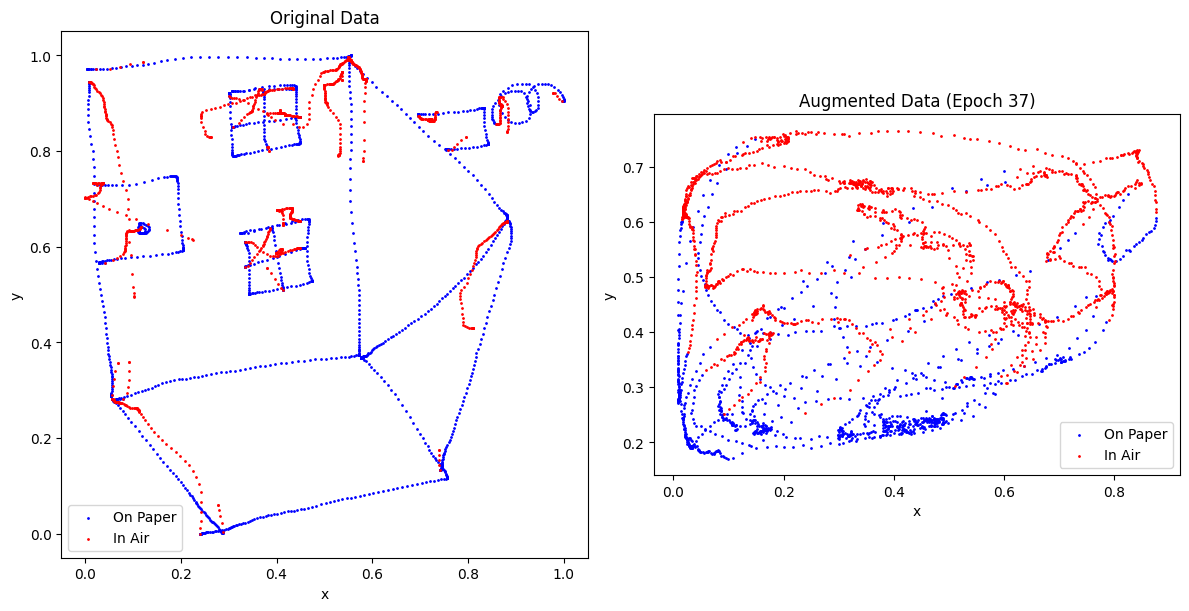


Epoch 38/50
--------------------


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 38 Summary:
  Total Loss: 0.894458
  Reconstruction Loss: 0.004364
  KL Loss: 0.567649
  Discriminator Loss: 1.414478
  Generator Loss: 0.890094
  Epoch processing time: 31.57 seconds
  No improvement. Patience: 22/30

Generating and visualizing augmented data for this epoch...


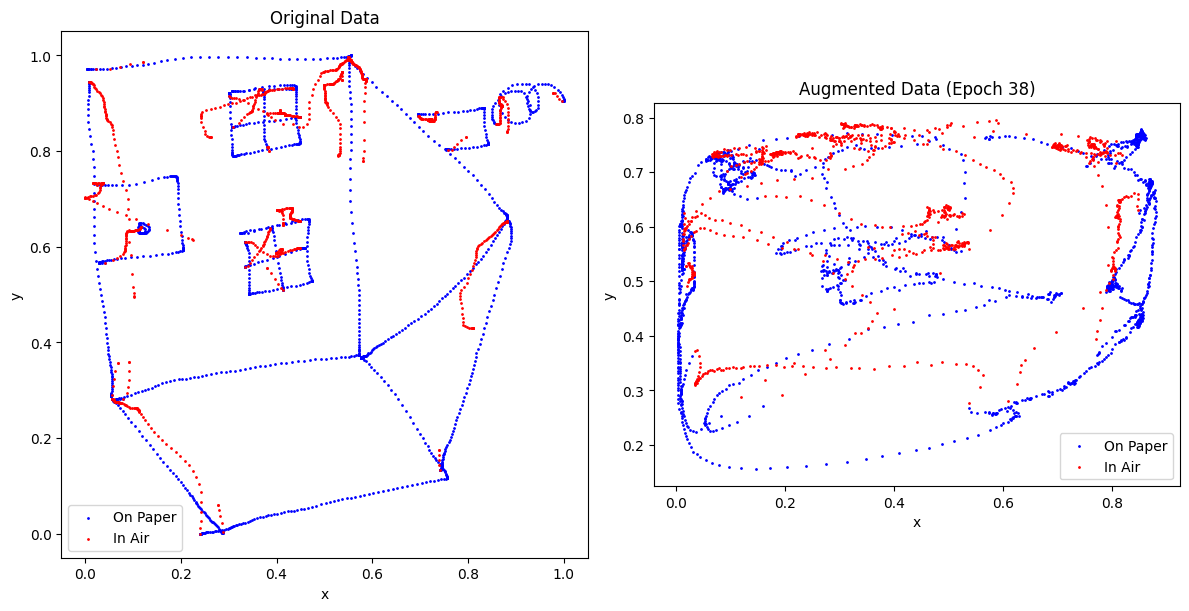


Epoch 39/50
--------------------


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 39 Summary:
  Total Loss: 0.919729
  Reconstruction Loss: 0.004436
  KL Loss: 0.575651
  Discriminator Loss: 1.422476
  Generator Loss: 0.915293
  Epoch processing time: 33.49 seconds
  No improvement. Patience: 23/30

Generating and visualizing augmented data for this epoch...


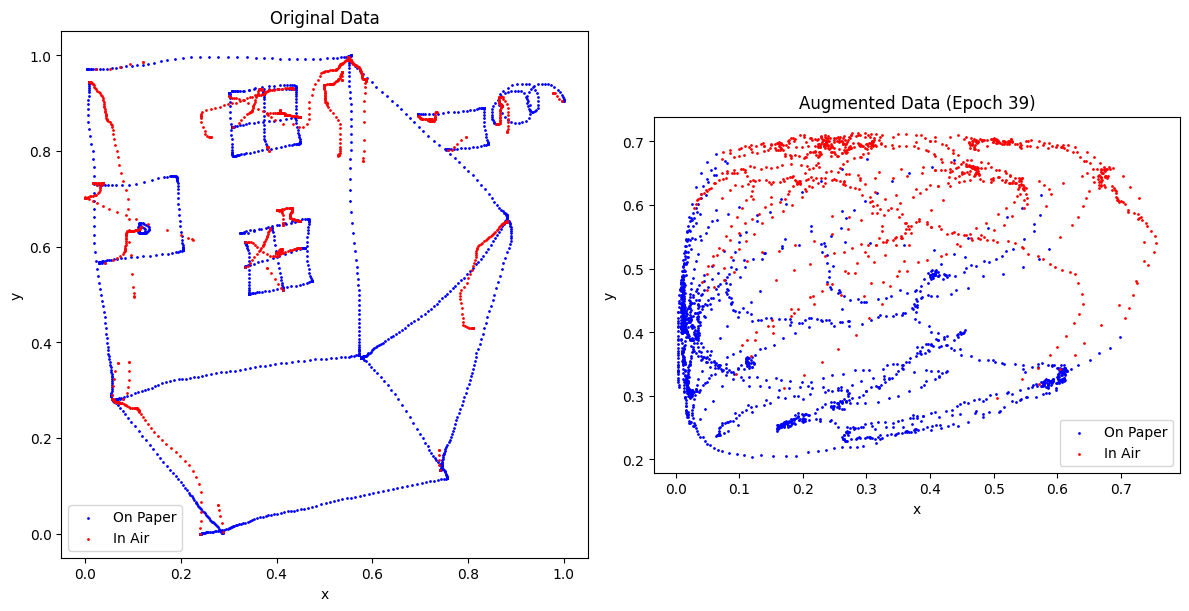


Epoch 40/50
--------------------


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 40 Summary:
  Total Loss: 0.931418
  Reconstruction Loss: 0.003598
  KL Loss: 0.582802
  Discriminator Loss: 1.426665
  Generator Loss: 0.927820
  Epoch processing time: 29.64 seconds
  No improvement. Patience: 24/30

Generating and visualizing augmented data for this epoch...


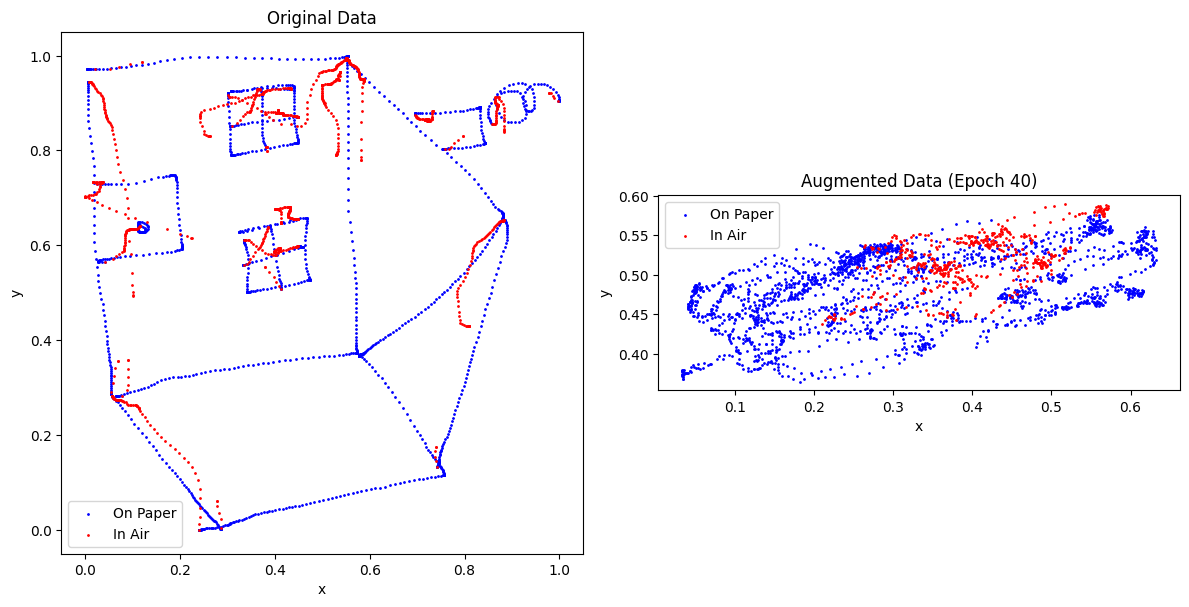


Epoch 41/50
--------------------


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 41 Summary:
  Total Loss: 0.932923
  Reconstruction Loss: 0.003387
  KL Loss: 0.589284
  Discriminator Loss: 1.427322
  Generator Loss: 0.929536
  Epoch processing time: 29.94 seconds
  No improvement. Patience: 25/30

Generating and visualizing augmented data for this epoch...


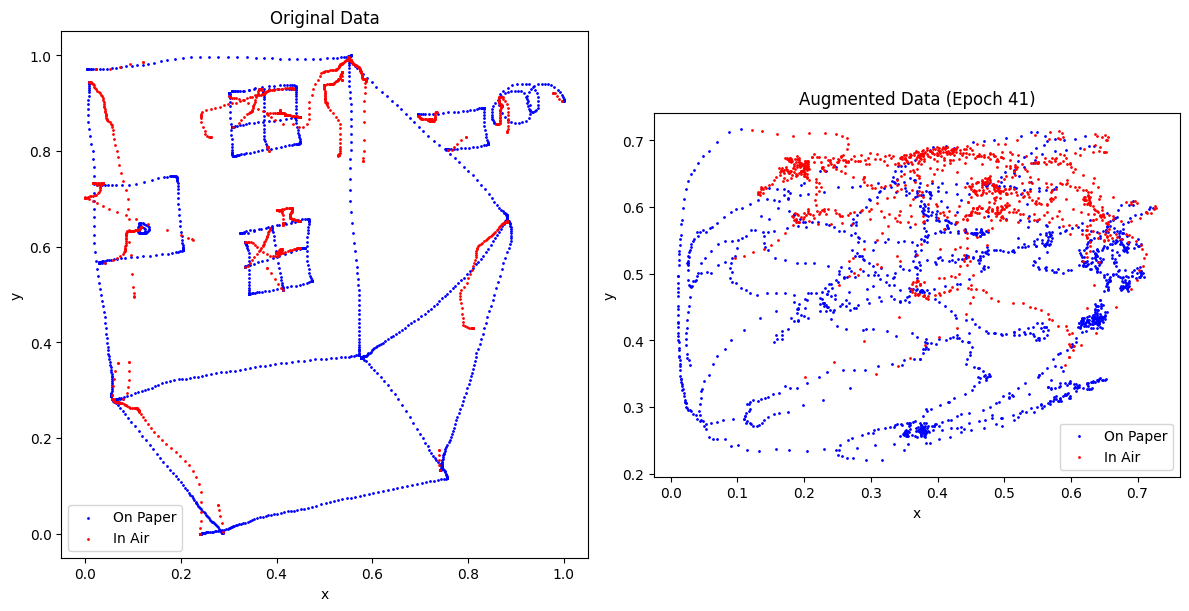


Epoch 42/50
--------------------


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 42 Summary:
  Total Loss: 0.925909
  Reconstruction Loss: 0.003174
  KL Loss: 0.595229
  Discriminator Loss: 1.425205
  Generator Loss: 0.922734
  Epoch processing time: 28.85 seconds
  No improvement. Patience: 26/30

Generating and visualizing augmented data for this epoch...


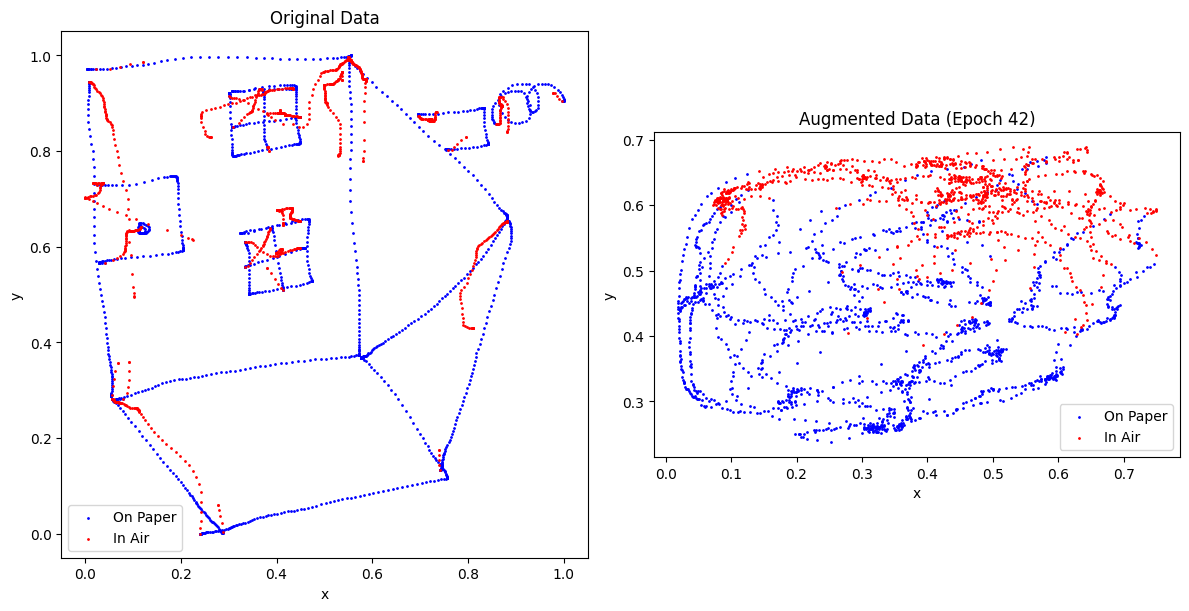


Epoch 43/50
--------------------


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 43 Summary:
  Total Loss: 0.912786
  Reconstruction Loss: 0.002920
  KL Loss: 0.600481
  Discriminator Loss: 1.421099
  Generator Loss: 0.909866
  Epoch processing time: 27.94 seconds
  No improvement. Patience: 27/30

Generating and visualizing augmented data for this epoch...


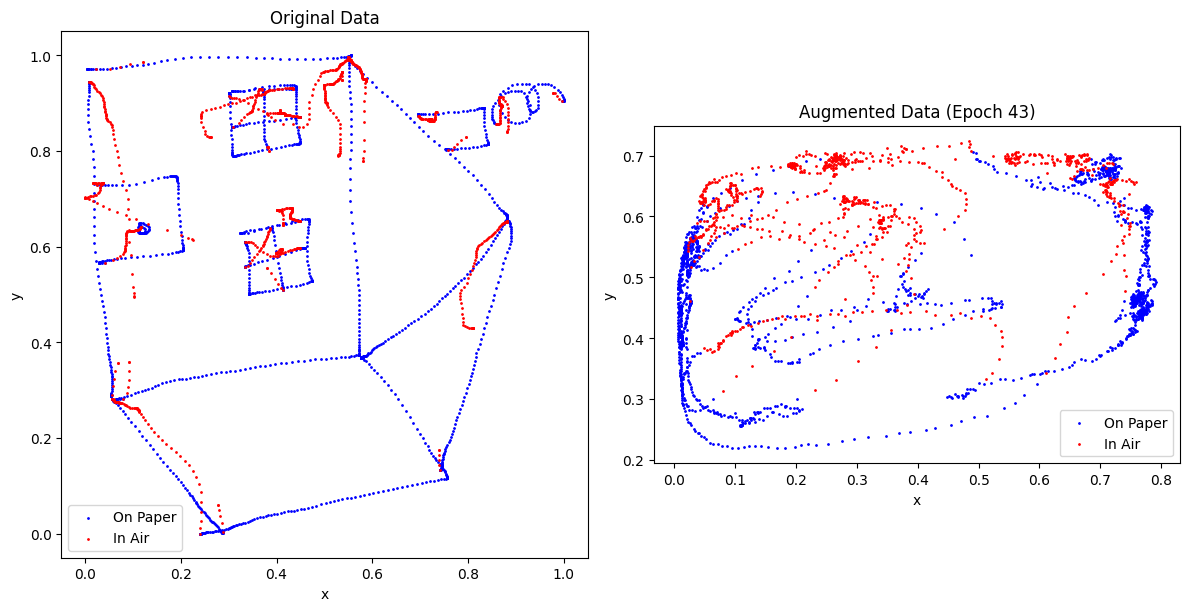


Epoch 44/50
--------------------


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 44 Summary:
  Total Loss: 0.895703
  Reconstruction Loss: 0.003006
  KL Loss: 0.605198
  Discriminator Loss: 1.415994
  Generator Loss: 0.892697
  Epoch processing time: 25.94 seconds
  No improvement. Patience: 28/30

Generating and visualizing augmented data for this epoch...


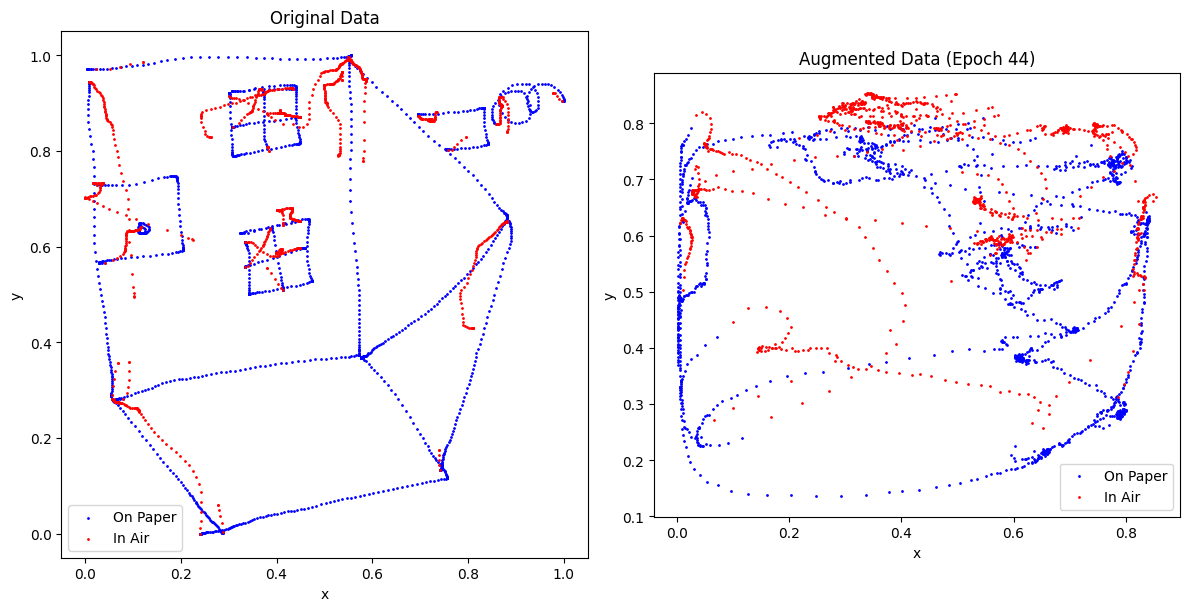


Epoch 45/50
--------------------


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 45 Summary:
  Total Loss: 0.875521
  Reconstruction Loss: 0.002570
  KL Loss: 0.609352
  Discriminator Loss: 1.410494
  Generator Loss: 0.872951
  Epoch processing time: 31.14 seconds
  No improvement. Patience: 29/30

Generating and visualizing augmented data for this epoch...


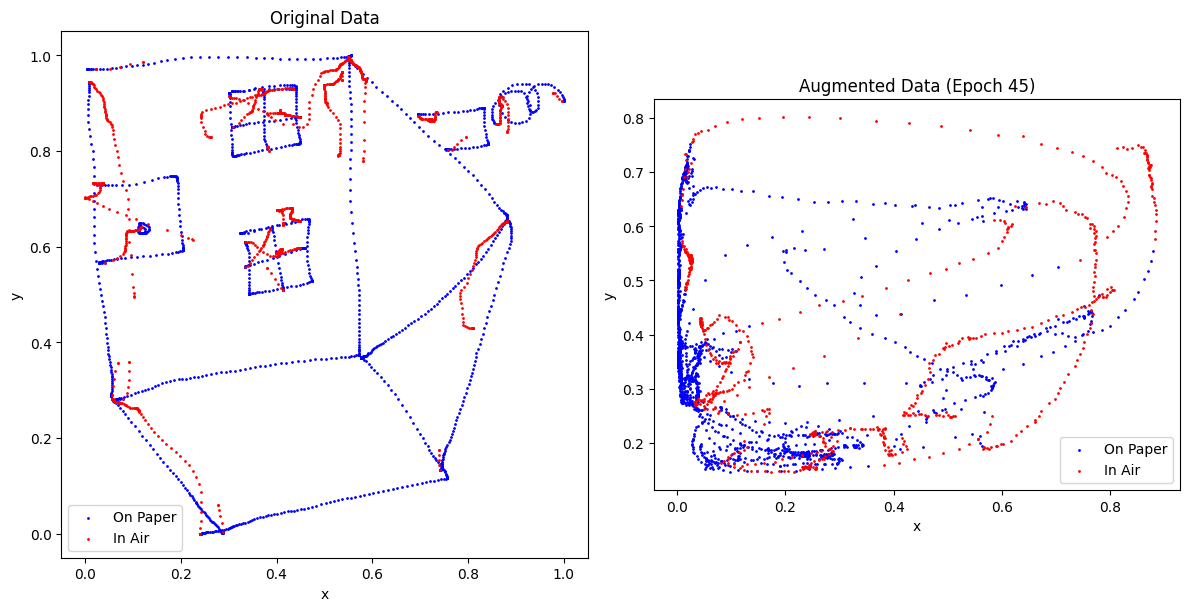


Epoch 46/50
--------------------


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?batch/s]


Epoch 46 Summary:
  Total Loss: 0.854257
  Reconstruction Loss: 0.002378
  KL Loss: 0.613087
  Discriminator Loss: 1.405074
  Generator Loss: 0.851879
  Epoch processing time: 29.68 seconds
  No improvement. Patience: 30/30

Generating and visualizing augmented data for this epoch...


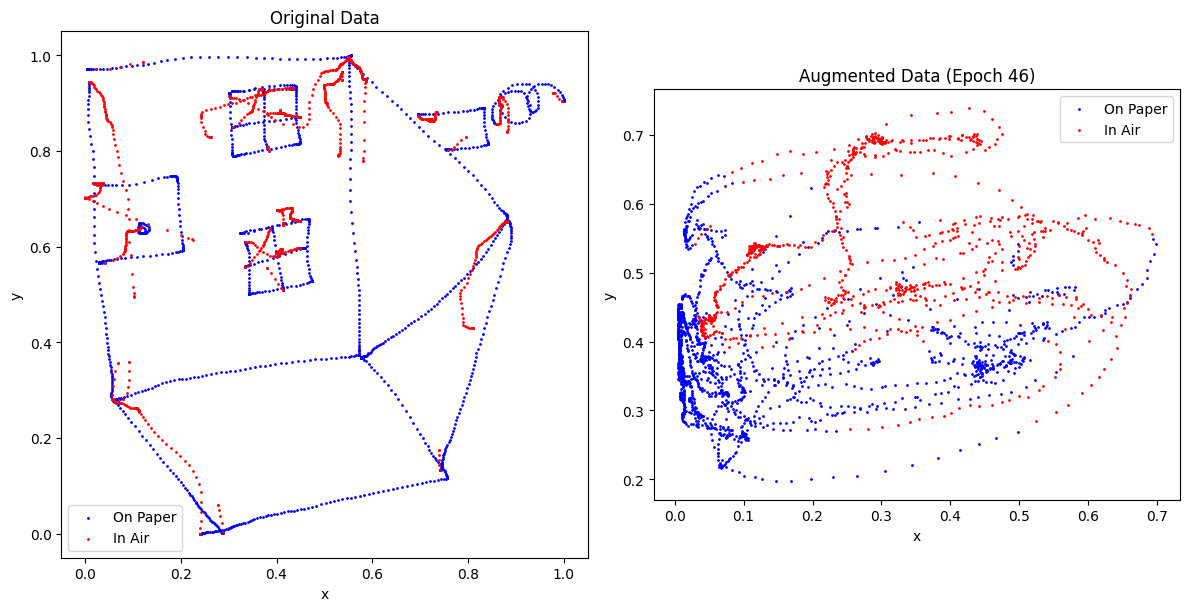


Early stopping triggered at epoch 46

Training completed.


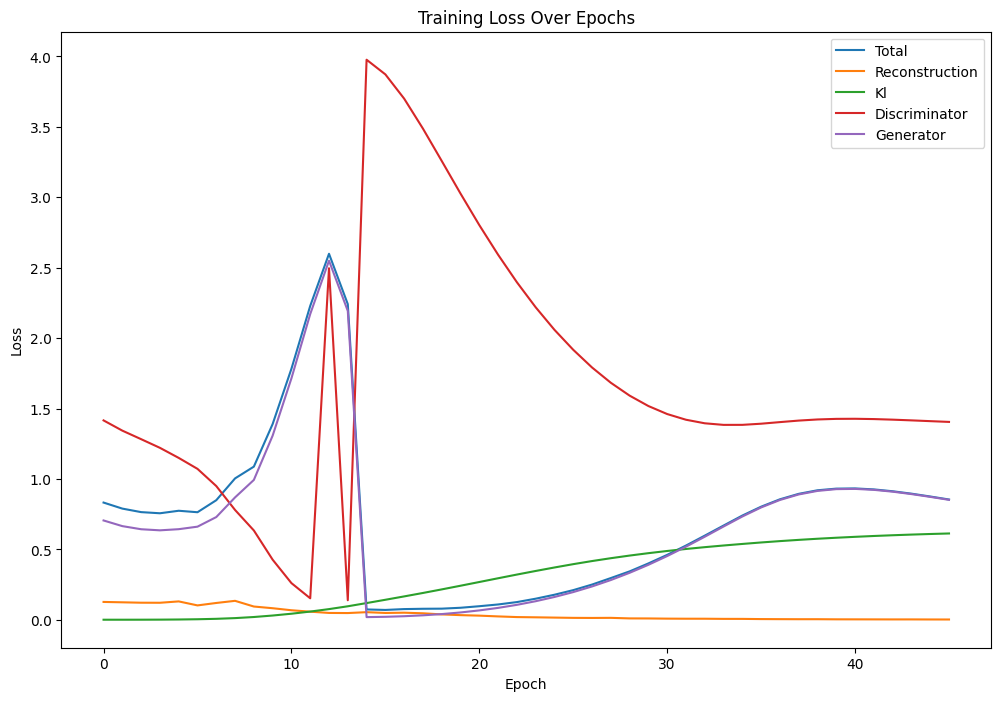

Final visualization of augmented data:


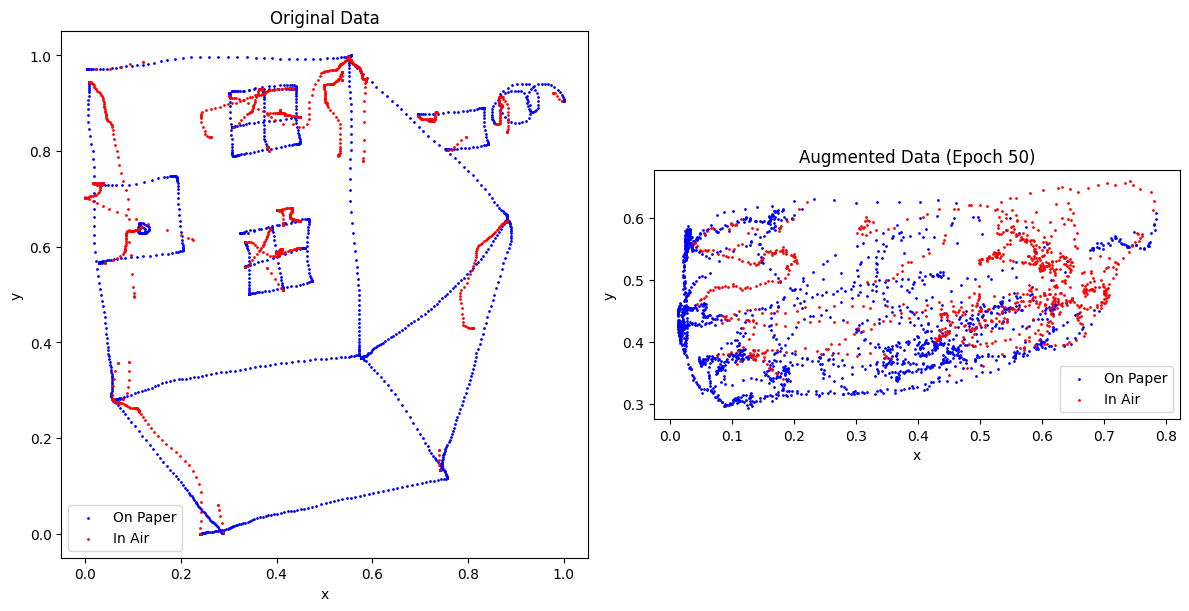

Visualization complete.


In [4]:
# Cell 4 (Training Loop with Per-Epoch Visualization)

import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Hyperparameters
latent_dim = 256
sequence_length = avg_data_points
feature_dim = 4  # x, y, timestamp, pen_status
beta = 0.0000001
learning_rate_vae = 0.001
learning_rate_disc = 0.001
batch_size = 512
epochs = 50
early_stopping_patience = 30
min_delta = 0.0001

# Create VAEGAN model
vaegan = VAEGAN(latent_dim, sequence_length, feature_dim, beta)
optimizer_vae = tf.keras.optimizers.Adam(learning_rate_vae)
optimizer_disc = tf.keras.optimizers.Adam(learning_rate_disc)

# Prepare the dataset
combined_data_reshaped = combined_data.reshape(-1, sequence_length, feature_dim)
train_dataset = tf.data.Dataset.from_tensor_slices(combined_data_reshaped).shuffle(10000).batch(batch_size)

# Function to generate and visualize augmented data
def visualize_augmented_data(epoch, original_data, model):
    plt.figure(figsize=(12, 6))
    
    # Plot original data
    original_on_paper = original_data[original_data[:, 3] == 1]
    original_in_air = original_data[original_data[:, 3] == 0]
    plt.subplot(1, 2, 1)
    plt.scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
    plt.scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
    plt.title('Original Data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')

    # Generate and plot augmented data
    z = tf.random.normal(shape=(1, latent_dim))
    augmented_data = model.decode(z).numpy().reshape(-1, feature_dim)
    augmented_on_paper = augmented_data[augmented_data[:, 3] > 0.5]
    augmented_in_air = augmented_data[augmented_data[:, 3] <= 0.5]
    plt.subplot(1, 2, 2)
    plt.scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
    plt.scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
    plt.title(f'Augmented Data (Epoch {epoch+1})')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')

    plt.tight_layout()
    plt.show()

# Training loop
best_loss = float('inf')
patience_counter = 0
loss_history = {'total': [], 'reconstruction': [], 'kl': [], 'discriminator': [], 'generator': []}

print("Starting training...")
print(f"Total number of batches per epoch: {len(train_dataset)}")

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("--------------------")
    
    epoch_start_time = time.time()
    total_loss = 0
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    disc_loss_sum = 0
    gen_loss_sum = 0
    num_batches = len(train_dataset)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for batch_idx, batch in enumerate(train_dataset):
            batch_start_time = time.time()
            
            total_loss_batch, reconstruction_loss, kl_loss, disc_loss, gen_loss = train_step(vaegan, batch, optimizer_vae, optimizer_disc)
            
            total_loss += total_loss_batch
            reconstruction_loss_sum += reconstruction_loss
            kl_loss_sum += kl_loss
            disc_loss_sum += disc_loss
            gen_loss_sum += gen_loss
            
            batch_time = time.time() - batch_start_time
            
            # Update progress bar every 10 batches
            if (batch_idx + 1) % 10 == 0 or batch_idx == num_batches - 1:
                pbar.update(10 if batch_idx != num_batches - 1 else num_batches % 10)
                pbar.set_postfix({
                    'Total Loss': f'{float(total_loss_batch):.4f}',
                    'Recon Loss': f'{float(reconstruction_loss):.4f}',
                    'KL Loss': f'{float(kl_loss):.4f}',
                    'Disc Loss': f'{float(disc_loss):.4f}',
                    'Gen Loss': f'{float(gen_loss):.4f}',
                    'Batch Time': f'{batch_time:.2f}s'
                })
                
            # Print detailed log every 100 batches
            if (batch_idx + 1) % 100 == 0:
                print(f"\nBatch {batch_idx + 1}/{num_batches}:")
                print(f"  Total Loss: {float(total_loss_batch):.6f}")
                print(f"  Reconstruction Loss: {float(reconstruction_loss):.6f}")
                print(f"  KL Loss: {float(kl_loss):.6f}")
                print(f"  Discriminator Loss: {float(disc_loss):.6f}")
                print(f"  Generator Loss: {float(gen_loss):.6f}")
                print(f"  Batch processing time: {batch_time:.2f} seconds")

    # Calculate average losses
    avg_total_loss = total_loss / num_batches
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches
    avg_disc_loss = disc_loss_sum / num_batches
    avg_gen_loss = gen_loss_sum / num_batches

    # Update loss history
    loss_history['total'].append(avg_total_loss)
    loss_history['reconstruction'].append(avg_reconstruction_loss)
    loss_history['kl'].append(avg_kl_loss)
    loss_history['discriminator'].append(avg_disc_loss)
    loss_history['generator'].append(avg_gen_loss)

    epoch_time = time.time() - epoch_start_time
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Total Loss: {avg_total_loss:.6f}")
    print(f"  Reconstruction Loss: {avg_reconstruction_loss:.6f}")
    print(f"  KL Loss: {avg_kl_loss:.6f}")
    print(f"  Discriminator Loss: {avg_disc_loss:.6f}")
    print(f"  Generator Loss: {avg_gen_loss:.6f}")
    print(f"  Epoch processing time: {epoch_time:.2f} seconds")

    # Early stopping check
    if avg_total_loss < best_loss - min_delta:
        best_loss = avg_total_loss
        patience_counter = 0
        print("  New best loss achieved!")
    else:
        patience_counter += 1
        print(f"  No improvement. Patience: {patience_counter}/{early_stopping_patience}")

    # Visualize augmented data after each epoch
    print("\nGenerating and visualizing augmented data for this epoch...")
    visualize_augmented_data(epoch, combined_data, vaegan)

    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print("\nTraining completed.")

# Plot loss history
plt.figure(figsize=(12, 8))
for loss_type, loss_values in loss_history.items():
    plt.plot(loss_values, label=loss_type.capitalize())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

print("Final visualization of augmented data:")
visualize_augmented_data(epochs-1, combined_data, vaegan)

print("Visualization complete.")

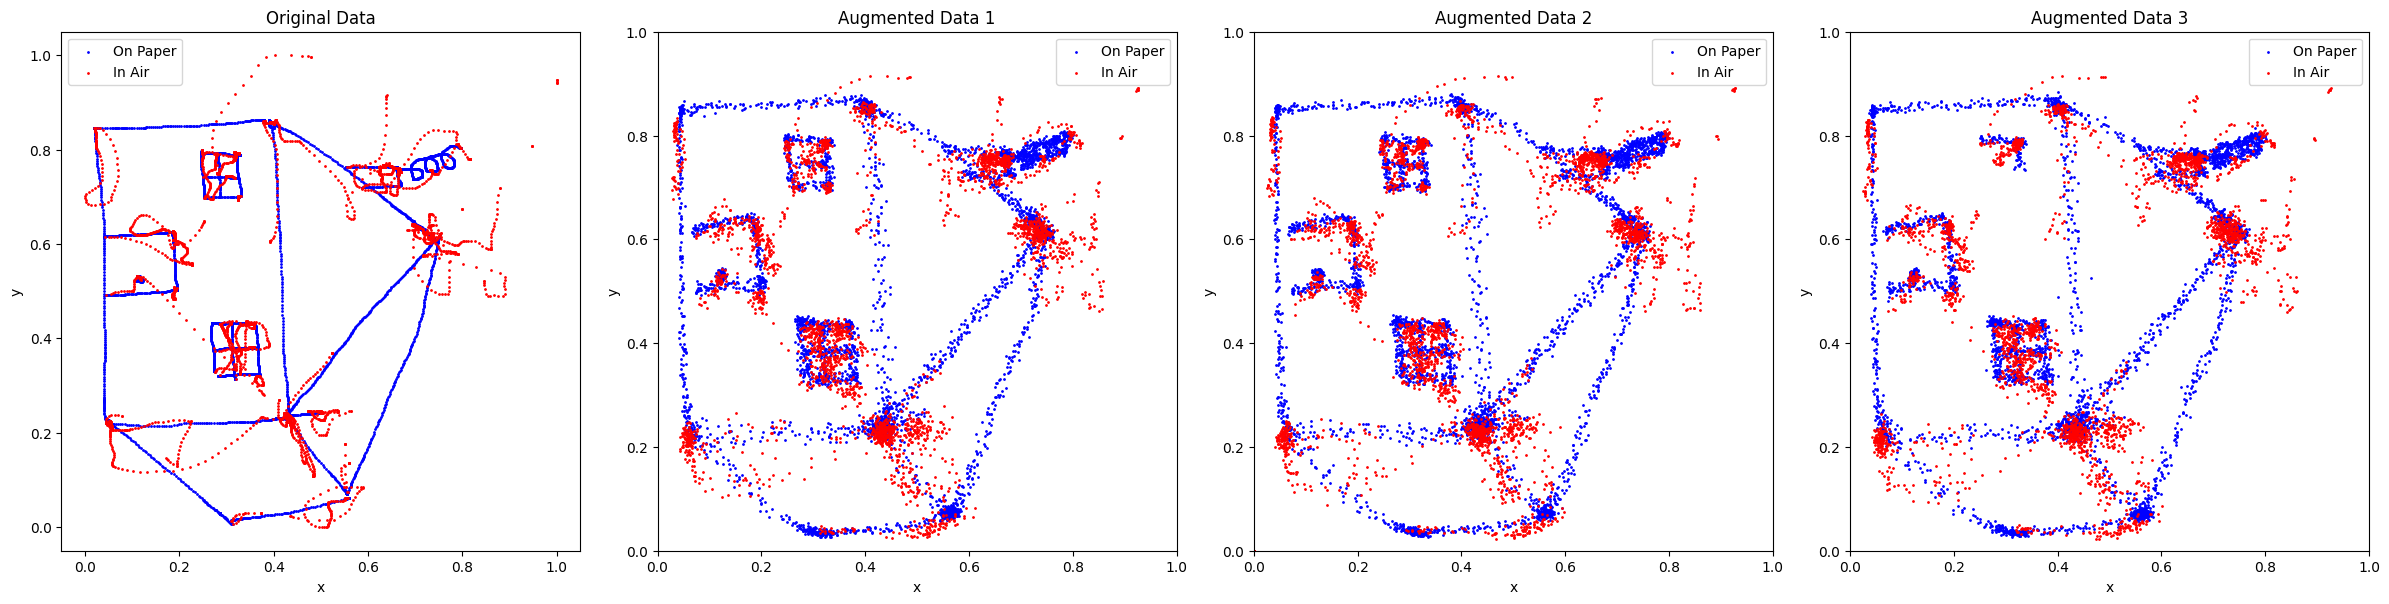

In [5]:
# Cell 5 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, variability=0.1):
    augmented_datasets = []
    
    for _ in range(num_augmented_files):
        mean, logvar = model.encode(tf.convert_to_tensor(combined_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar)
        augmented_data = model.decode(z).numpy()

        # Determine the number of data points for this augmented dataset
        num_points = int(avg_data_points * (1 + variability * (random.random() - 0.5) * 2))
        
        # Truncate or pad the augmented data to match the number of points
        if num_points < augmented_data.shape[0]:
            augmented_data = augmented_data[:num_points]
        else:
            padding = np.zeros((num_points - augmented_data.shape[0], augmented_data.shape[1]))
            augmented_data = np.vstack([augmented_data, padding])

        # Post-process pen status
        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        
        # Ensure timestamps are in sequence
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

num_augmented_files = 3
augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points)

# Visualize the original and augmented data side by side
fig, axs = plt.subplots(1, num_augmented_files + 1, figsize=(6*(num_augmented_files + 1), 6))
original_on_paper = combined_data[combined_data[:, 3] == 1]
original_in_air = combined_data[combined_data[:, 3] == 0]
axs[0].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
axs[0].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
axs[0].set_title('Original Data')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')
axs[0].legend()

# Set consistent axis limits for square aspect ratio
x_min, x_max = combined_data[:, 0].min(), combined_data[:, 0].max()
y_min, y_max = combined_data[:, 1].min(), combined_data[:, 1].max()

for i, augmented_data in enumerate(augmented_datasets):
    augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
    augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
    axs[i+1].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
    axs[i+1].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
    axs[i+1].set_title(f'Augmented Data {i+1}')
    axs[i+1].set_xlabel('x')
    axs[i+1].set_ylabel('y')
    axs[i+1].set_aspect('equal')
    axs[i+1].set_xlim(x_min, x_max)
    axs[i+1].set_ylim(y_min, y_max)
    axs[i+1].legend()

plt.tight_layout()
plt.show()

In [54]:
# Cell 6
def download_augmented_data(augmented_datasets, scaler, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, augmented_data in enumerate(augmented_datasets):
        augmented_data_original_scale = np.column_stack((
            scaler.inverse_transform(augmented_data[:, :3]),  # Inverse scale x, y, timestamp
            augmented_data[:, 3]  # Keep pen_status unchanged
        ))

        # Save each augmented dataset to a CSV file
        filename = os.path.join(directory, f'augmented_data_{i+1}.csv')
        pd.DataFrame(augmented_data_original_scale, columns=['x', 'y', 'timestamp', 'pen_status']).to_csv(filename, index=False)
        print(f"Saved {filename}")

# Call the updated function with the same scaler for all augmented datasets
download_augmented_data(augmented_datasets, scalers[0])


Saved augmented_data\augmented_data_1.csv
Saved augmented_data\augmented_data_2.csv
Saved augmented_data\augmented_data_3.csv
